# Import Libraries

In [2]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.vector_ar.var_model import VAR

import warnings
warnings.filterwarnings("ignore")

# Read the Dataset and Display Statistics

In [3]:
# Read the dataset
file_path = 'Dataset.xlsx'
data = pd.read_excel(file_path)

# Convert the dataset to a DataFrame
data = pd.DataFrame(data)

# Display summary statistics
summary_statistics = data.describe()
print(summary_statistics)

# Display missing values
missing_values = data.isnull().sum()
print(missing_values)

# Display the first few rows of the dataset
print(data.head())

                      Date       Temp         pH           EC          TA   
count                   60  60.000000  60.000000    60.000000   60.000000  \
mean   2017-06-16 06:24:00  23.868333   7.716667   930.531667  247.531667   
min    2015-01-01 00:00:00  16.900000   7.030000   135.700000   68.000000   
25%    2016-03-24 06:00:00  21.100000   7.317500   427.050000  162.325000   
50%    2017-06-16 00:00:00  23.750000   7.665000   894.050000  260.350000   
75%    2018-09-08 12:00:00  27.100000   8.147500  1327.650000  318.100000   
max    2019-12-01 00:00:00  29.600000   8.470000  1982.600000  396.700000   
std                    NaN   3.576737   0.450083   538.517380   89.875104   

               Cl         TDS         TSS         DO        BOD         COD   
count   60.000000   60.000000   60.000000  60.000000  60.000000   60.000000  \
mean    51.518333  471.335000   99.376667   2.518500  29.020000  133.438333   
min     11.000000   65.100000    9.000000   0.000000   2.100000   18.

# Replace Missing Values and Visualize Data

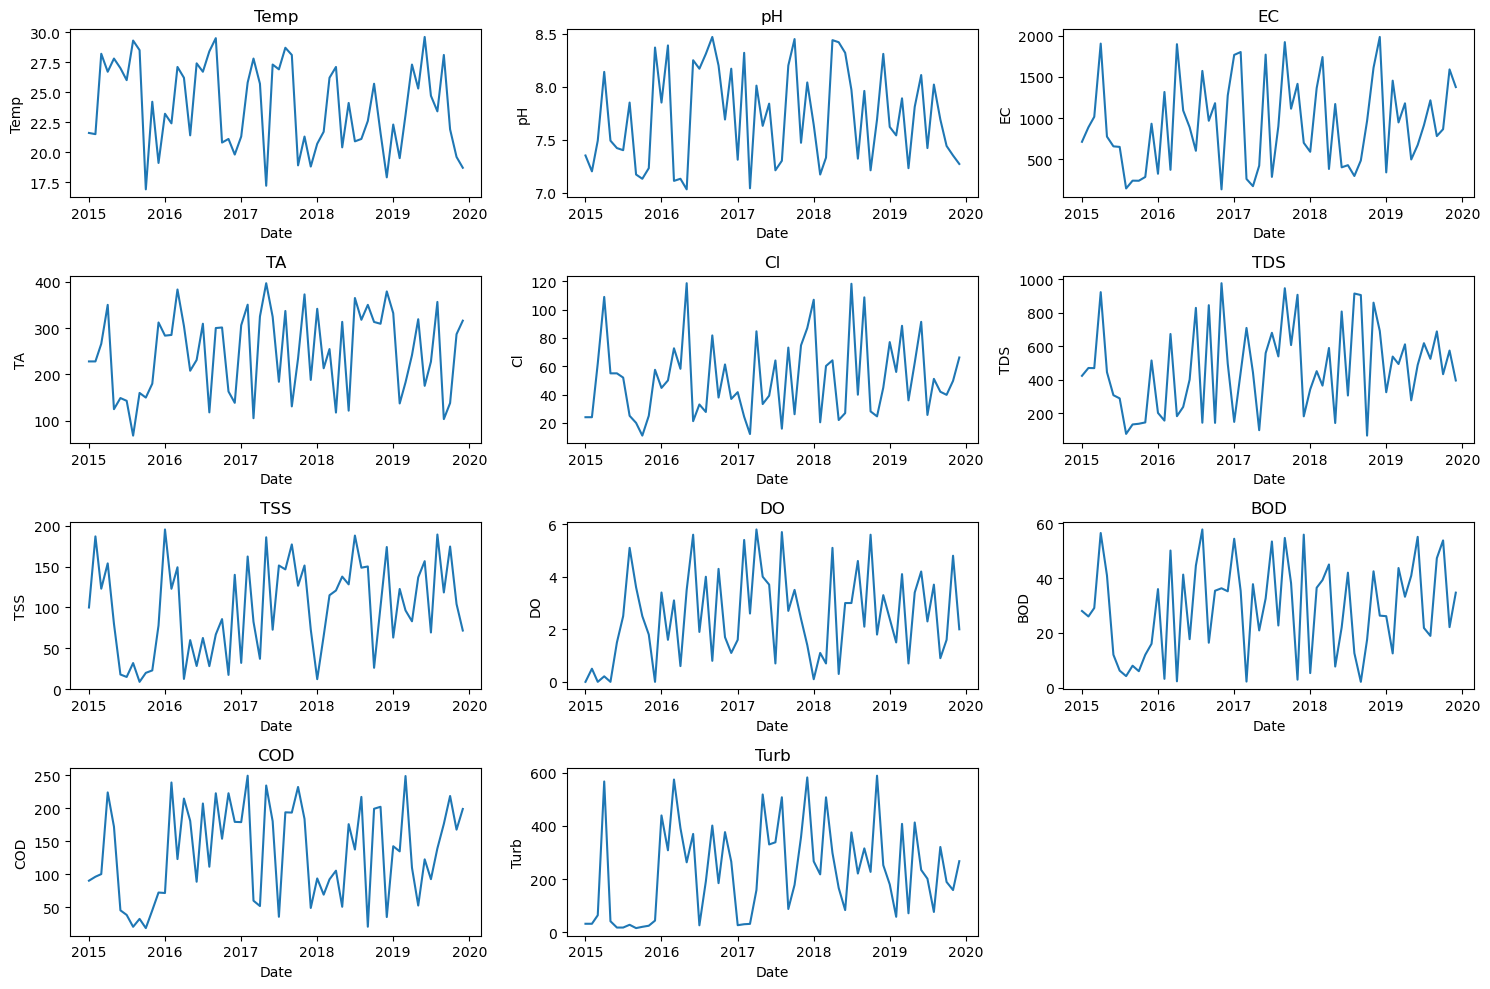

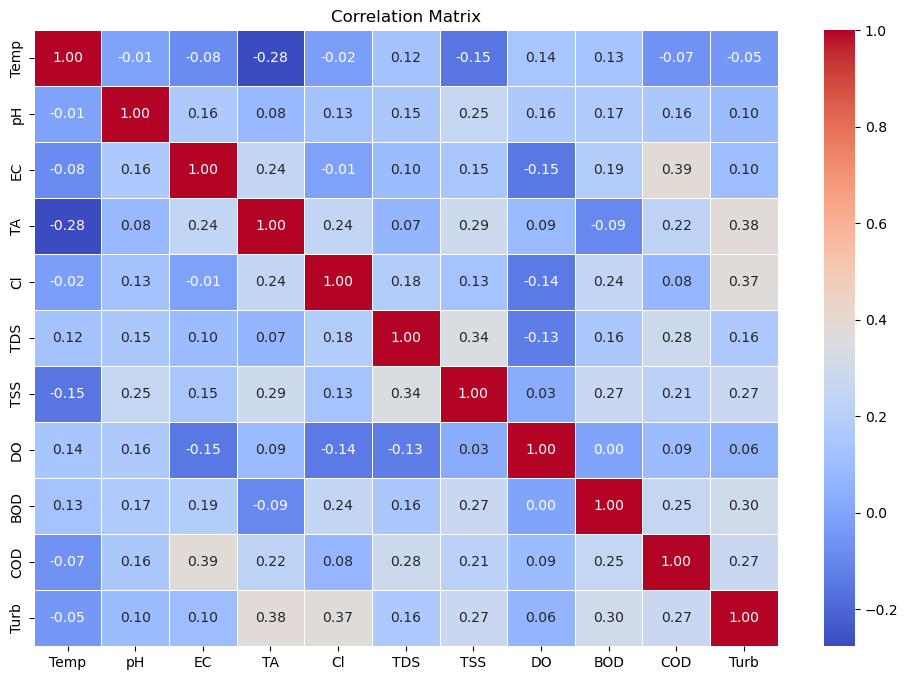

In [4]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

for column in data.columns:
    
    # Interpolate missing values
    data[column] = data[column].interpolate(method='linear')
    
    # Replace missing values with the mean of the column
    #data[column].fillna(data[column].mean(), inplace=True)
    
    # Replace missing values with the mode of the column
    #data[column].fillna(data[column].mode()[0], inplace=True)

# Forward fill
#data = data.fillna(method='ffill')

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Plot the data
plt.figure(figsize=(15, 10))

for i, column in enumerate(data.columns, 1):
    plt.subplot(4, 3, i)
    plt.plot(data.index, data[column], label=column)
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.tight_layout()

plt.show()

# Correlation matrix
correlation_matrix = data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Sarima Model ( Trial )

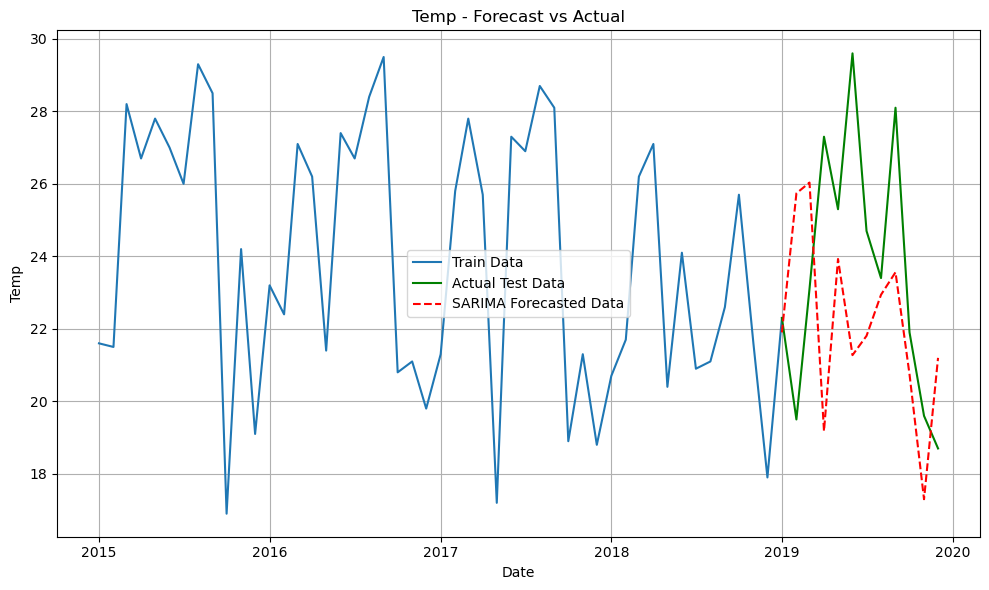

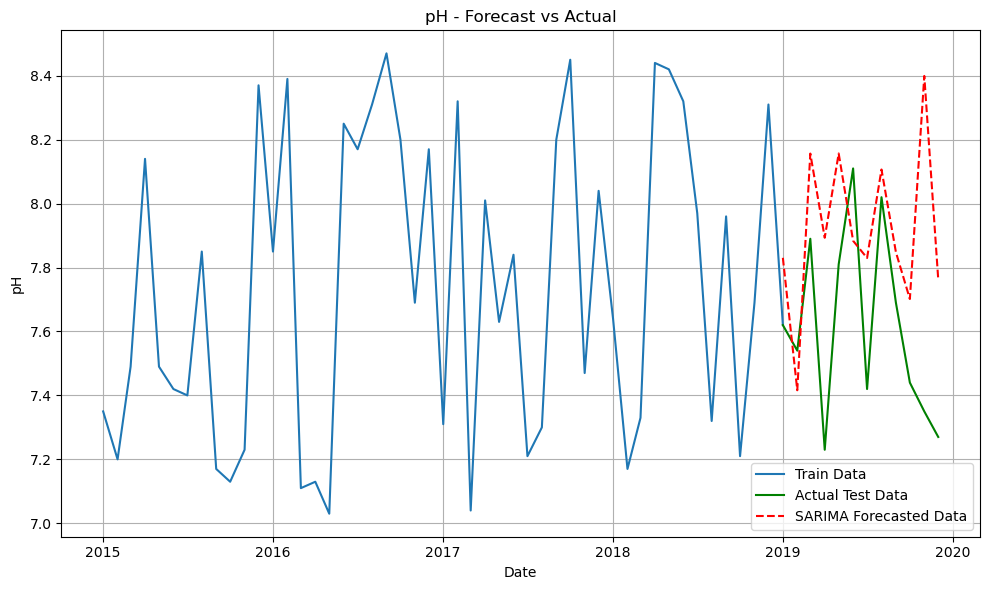

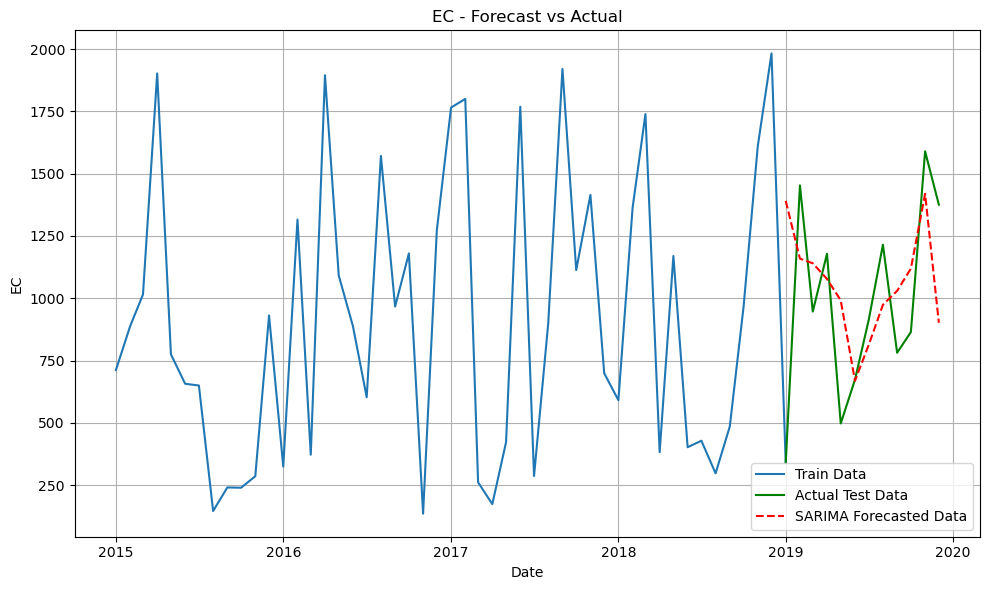

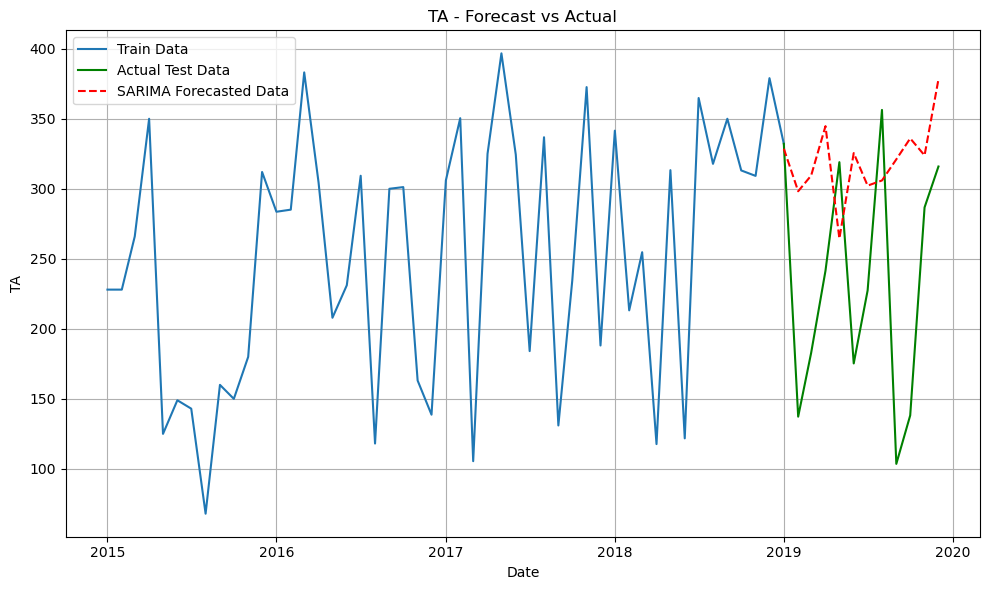

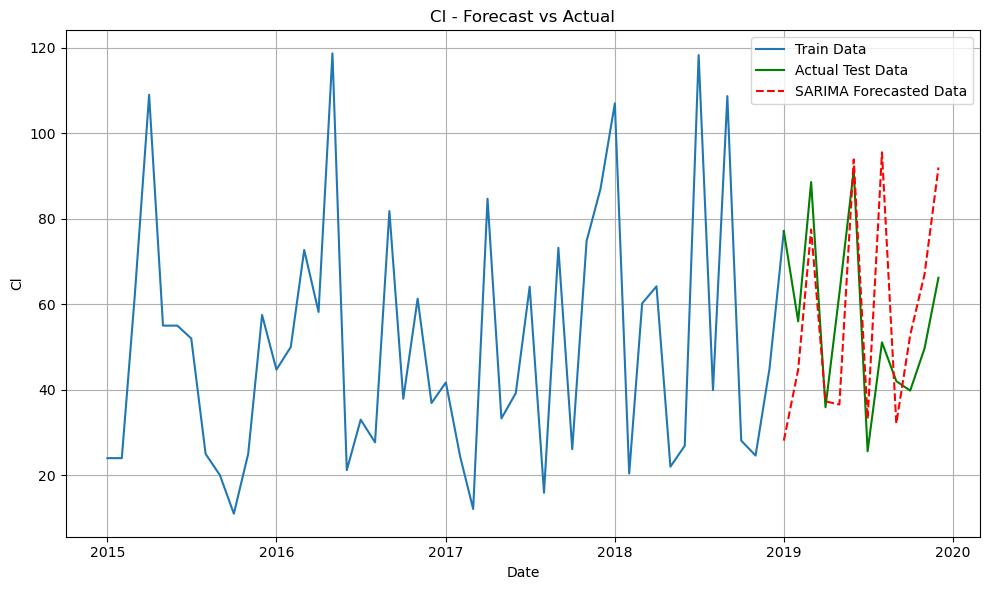

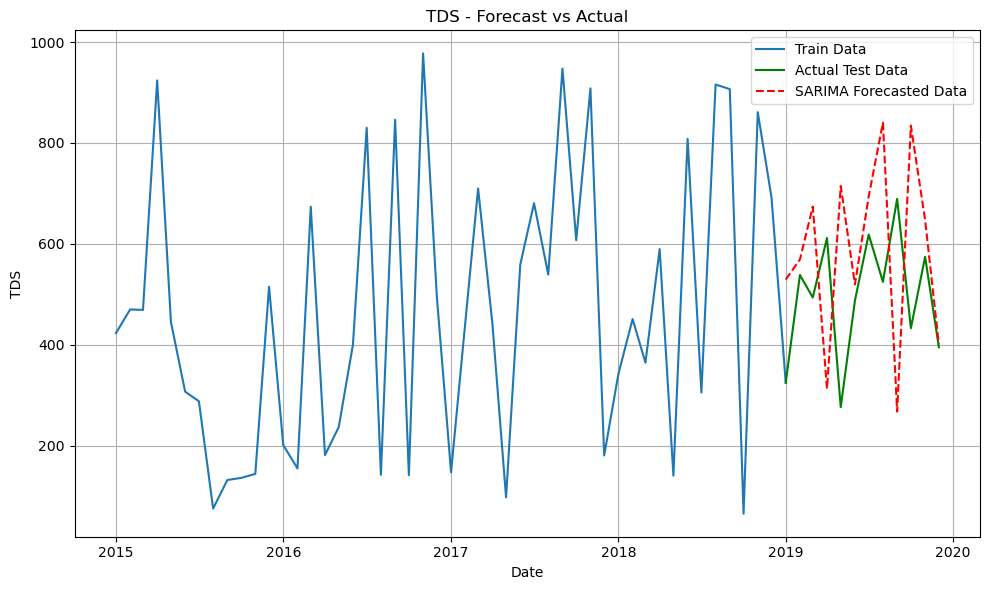

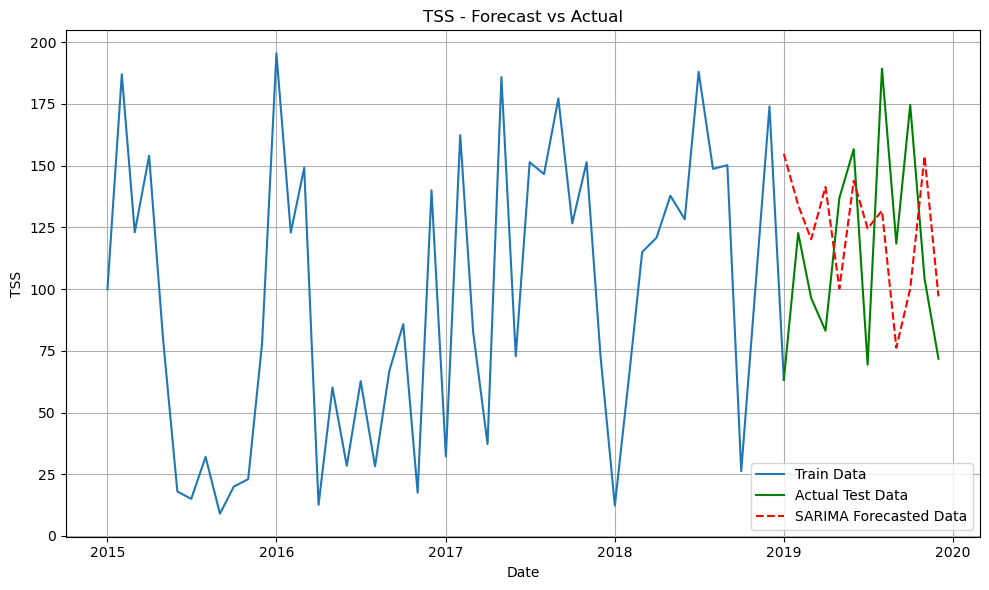

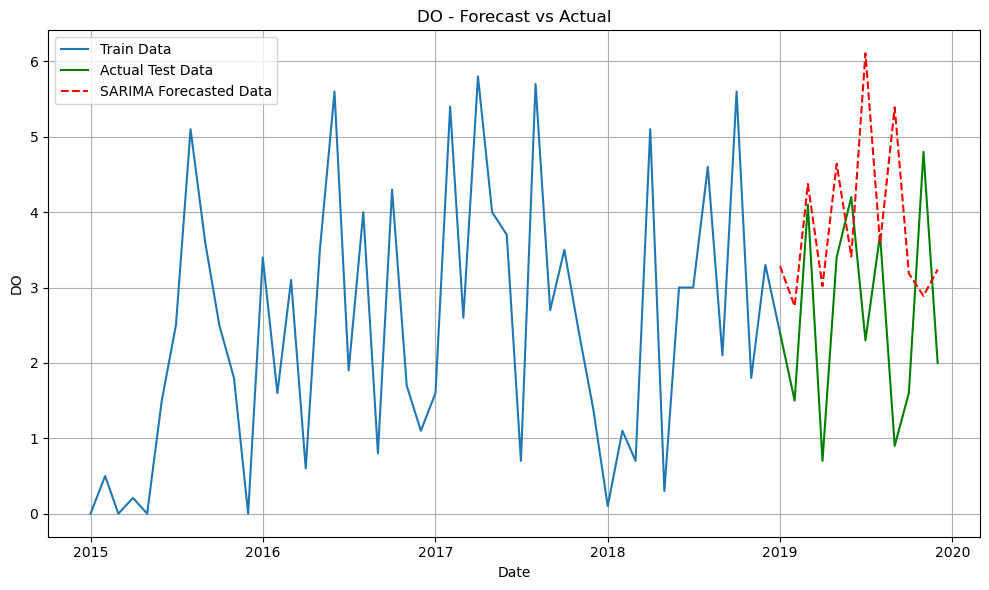

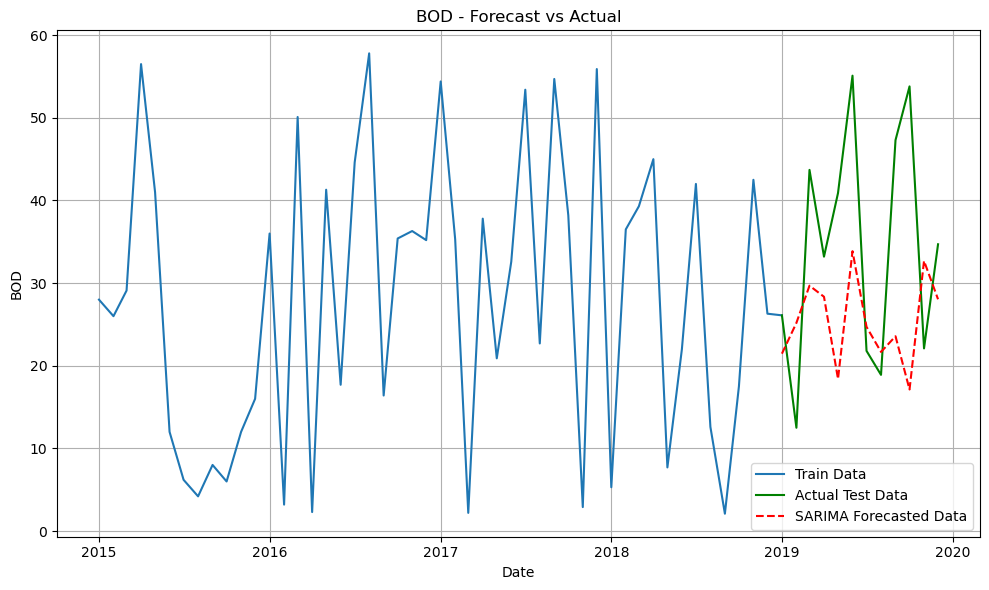

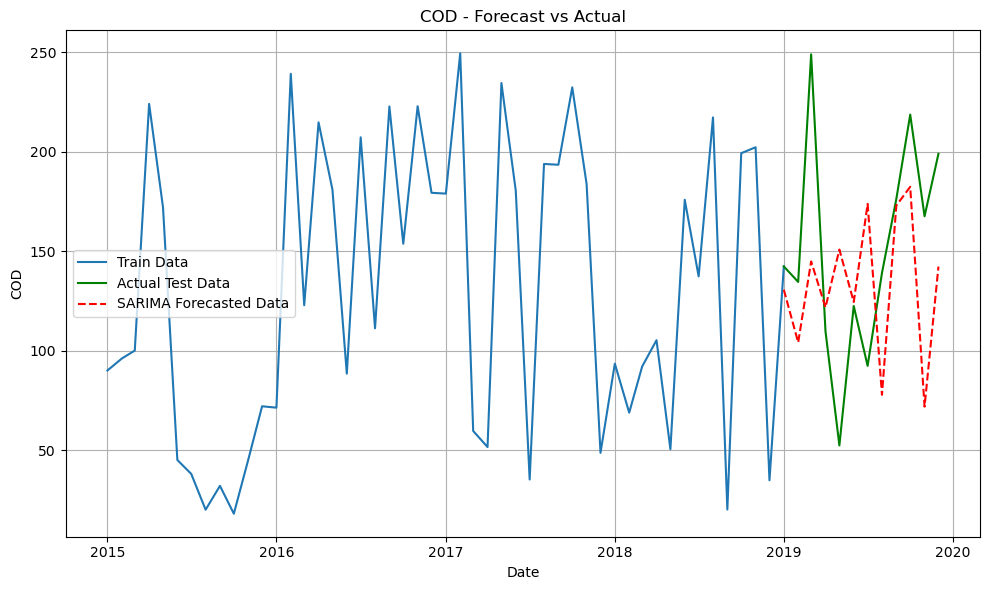

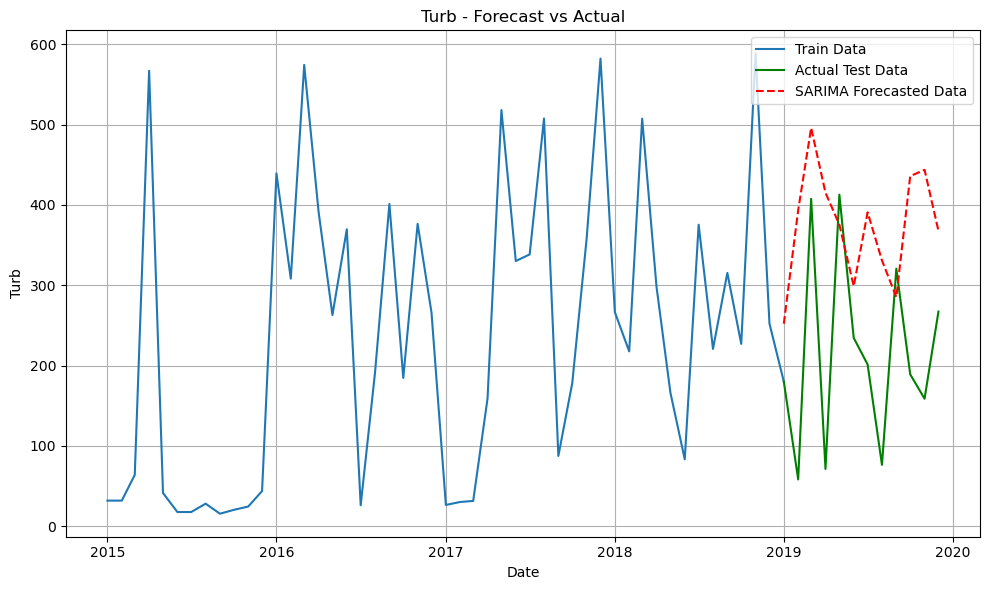

Accuracy for Temp:
  MAE: 3.4367891063124874
  MSE: 18.909022759199235
  RMSE: 4.3484506159319825
  MAPE: 14.167374184102286%
----------------------------------------
            Temp    pH      EC     TA     Cl    TDS    TSS    DO   BOD    COD   
Date                                                                            
2015-01-01  21.6  7.35   712.0  228.0   24.0  423.0  100.0  0.00  28.0   90.0  \
2015-02-01  21.5  7.20   888.0  228.0   24.0  470.0  187.0  0.50  26.0   96.0   
2015-03-01  28.2  7.49  1015.0  266.0   62.0  469.0  123.0  0.00  29.1  100.0   
2015-04-01  26.7  8.14  1902.0  350.0  109.0  924.0  154.0  0.21  56.5  224.0   
2015-05-01  27.8  7.49   775.0  125.0   55.0  445.0   80.0  0.00  41.0  172.0   

             Turb  
Date               
2015-01-01   32.0  
2015-02-01   32.0  
2015-03-01   64.0  
2015-04-01  567.0  
2015-05-01   41.5  
Accuracy for pH:
  MAE: 0.35791875593335765
  MSE: 0.19621457544146179
  RMSE: 0.44296114439244194
  MAPE: 4.784304478000318%

In [5]:
# Split the data into training and testing sets
train_data = data[data.index <= '2019-01-01']
test_data = data[data.index >= '2019-01-01']

# Create empty dataframe
sarima_predictions_old = pd.DataFrame()

# Number of forecast steps
forecast_steps = 12

# Loop through each column and fit the SARIMA model
for column in train_data.columns:    
    
    # Fit SARIMA model (P=1, D=1, Q=1, S=12 for yearly seasonality
    model = SARIMAX(train_data[column], 
                    order=(1, 1, 1), 
                    seasonal_order=(1, 1, 1, 12))
    
    # Fit the model
    fitted_model = model.fit(disp=False)
    
    # Forecast future values for the forecast period
    forecast = fitted_model.forecast(steps=forecast_steps)
    
    # Store the forecasted values
    sarima_predictions_old[column] = forecast


# Set the index for the forecast to cover the forecast period
sarima_predictions_old.index = pd.date_range(start='2019-01-01', periods=forecast_steps, freq='MS')

# Plot the forecasted values against the actual values
for column in train_data.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data[column], label='Train Data')
    plt.plot(test_data.index, test_data[column], label='Actual Test Data', color='green')
    plt.plot(sarima_predictions_old.index, sarima_predictions_old[column], label='SARIMA Forecasted Data', color='red', linestyle='--')
    
    plt.title(f"{column} - Forecast vs Actual")
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Calculate the accuracy metrics for each feature
mae_results = {}
mse_results = {}
rmse_results = {}
mape_results = {}

for column in test_data.columns:
    actual_values = test_data[column]  # Actual test data values
    predicted_values = sarima_predictions_old[column]  # Forecasted values
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, predicted_values)
    mae_results[column] = mae
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(actual_values, predicted_values)
    mse_results[column] = mse
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse_results[column] = rmse
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    mape_results[column] = mape
    
    # Print results for each feature
    print(f"Accuracy for {column}:")
    print(f"  MAE: {mae}")
    print(f"  MSE: {mse}")
    print(f"  RMSE: {rmse}")
    print(f"  MAPE: {mape}%")
    print("-" * 40)
    print(data.head())

# Auto Arima Model ( Trial )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=201.324, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=200.236, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=199.408, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=200.216, Time=0.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=202.201, Time=0.06 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=199.721, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=201.407, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.621 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=81.707, Time=0.02 sec

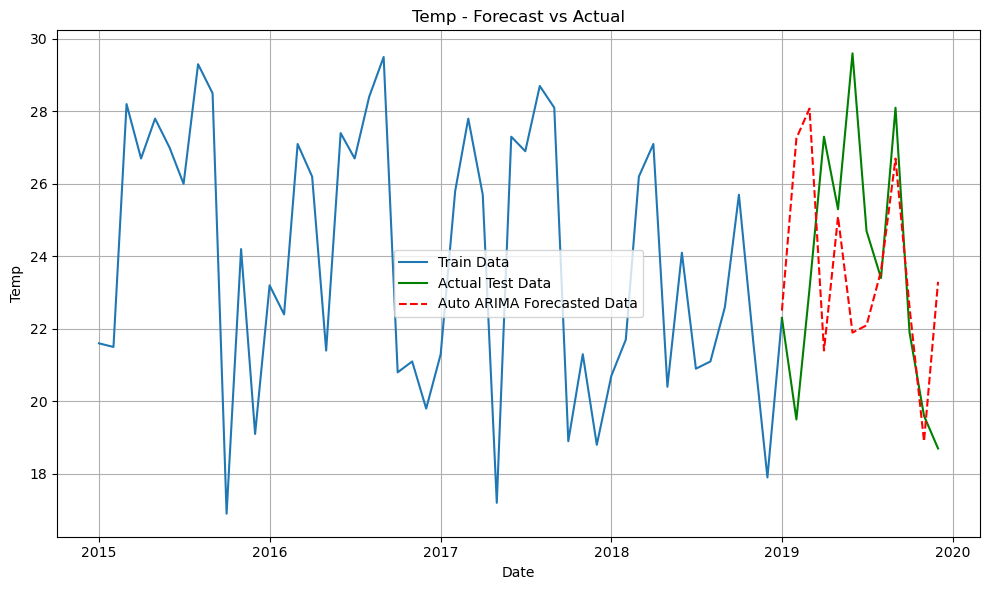

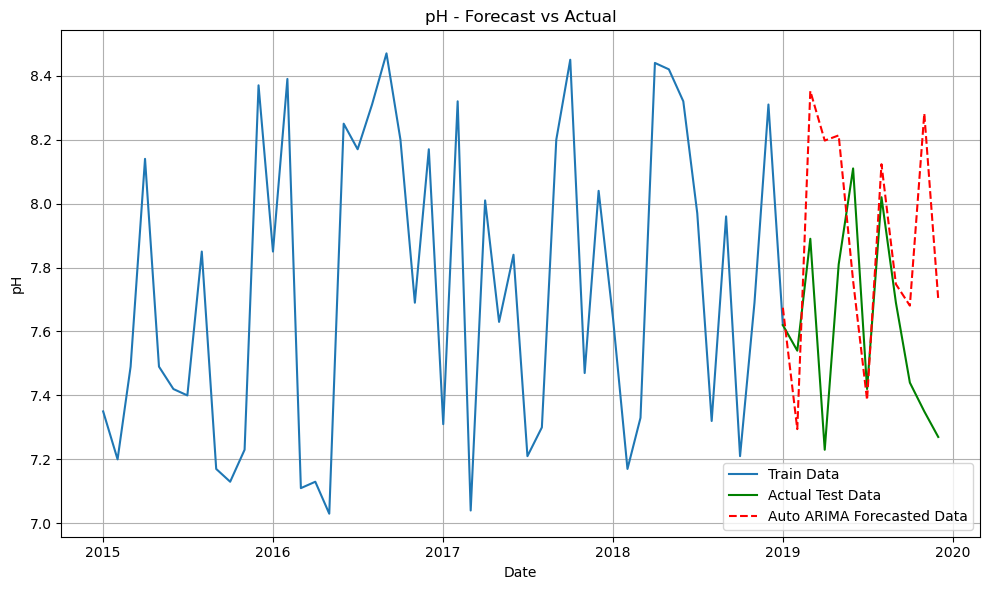

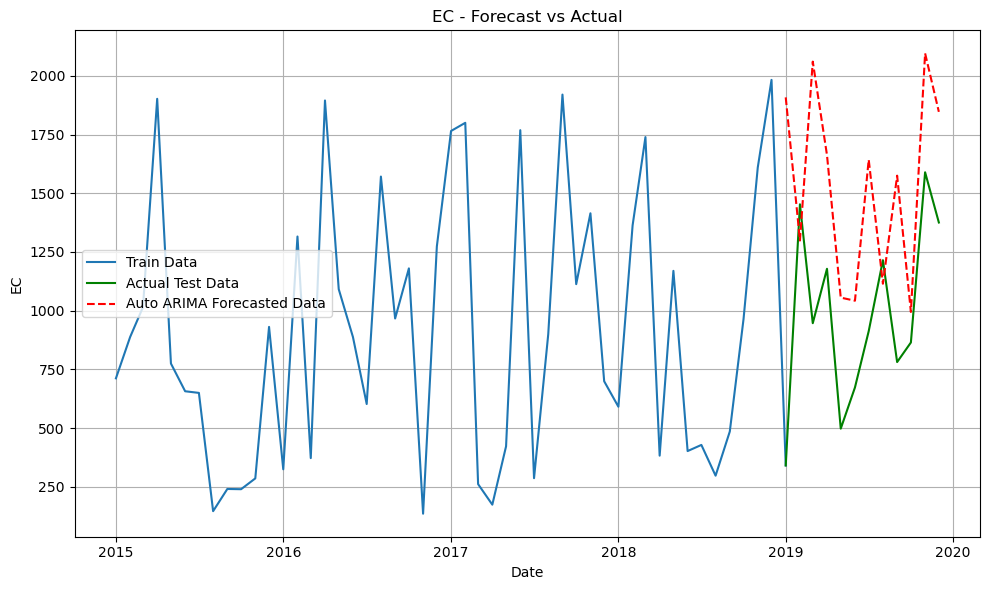

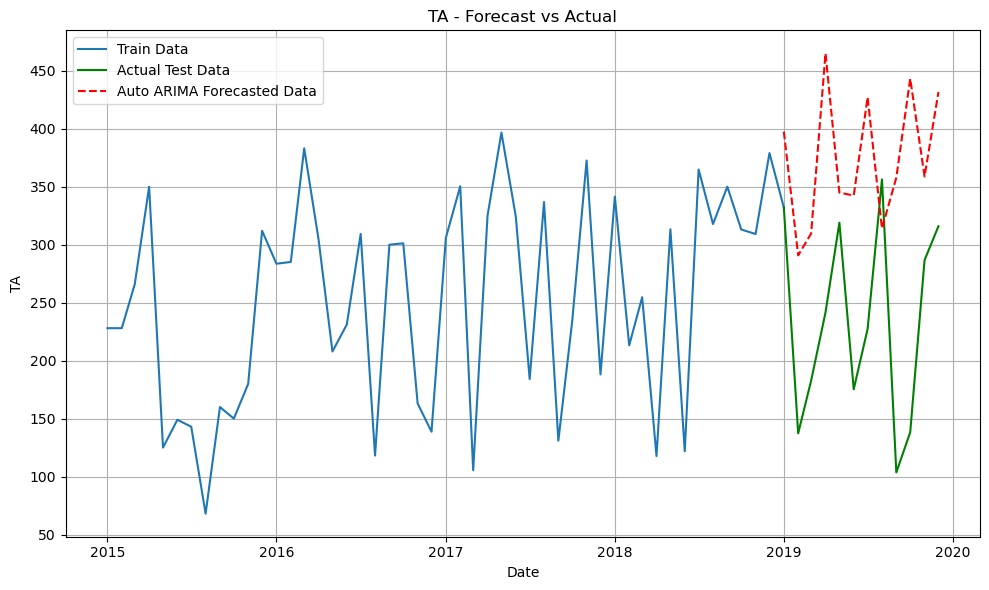

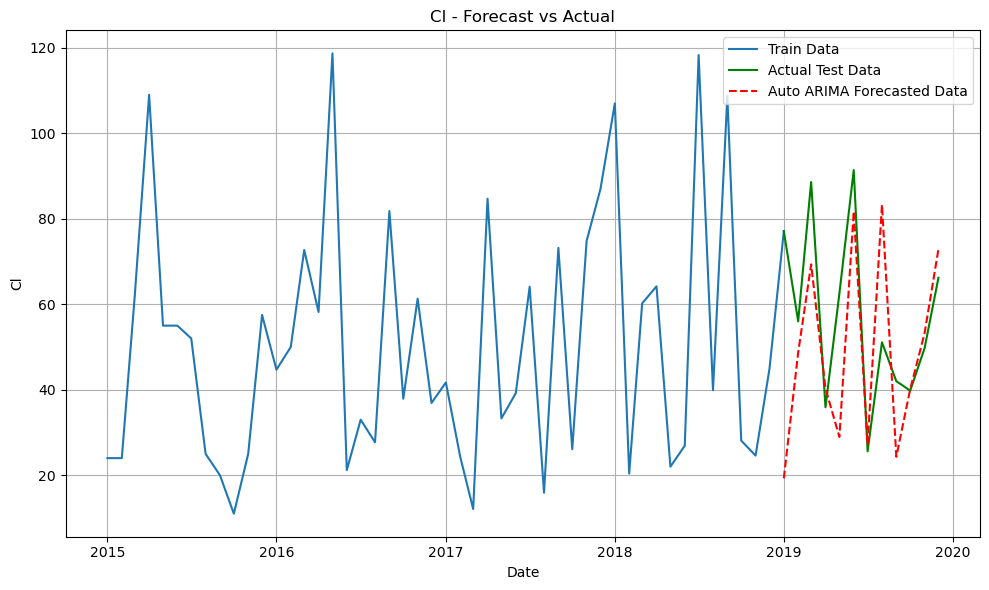

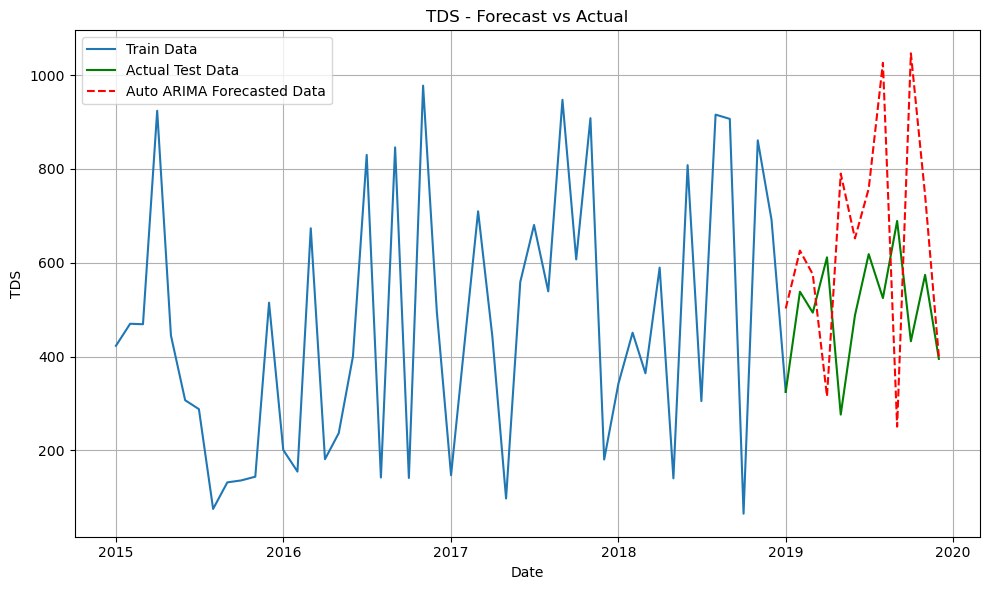

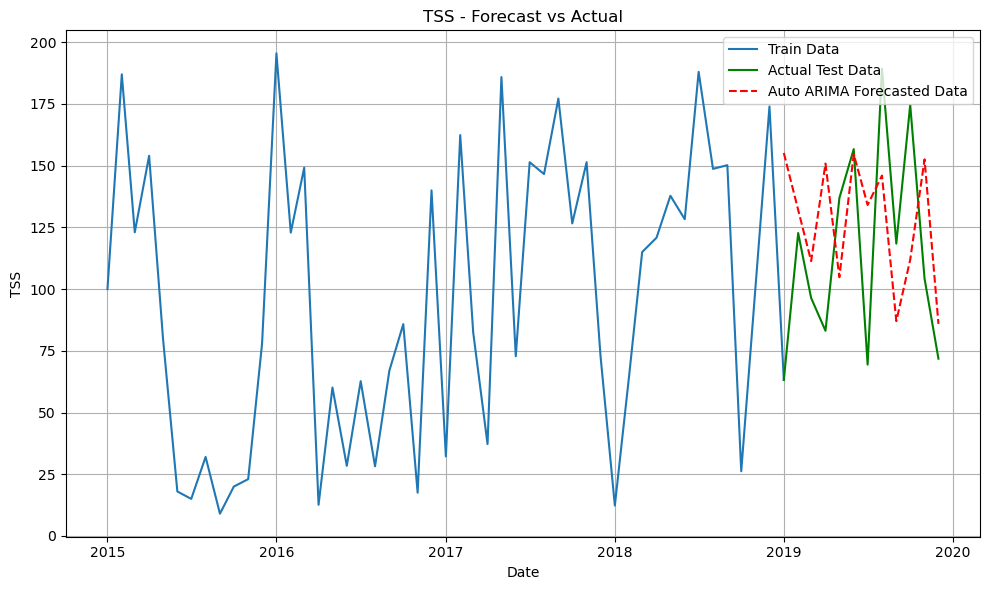

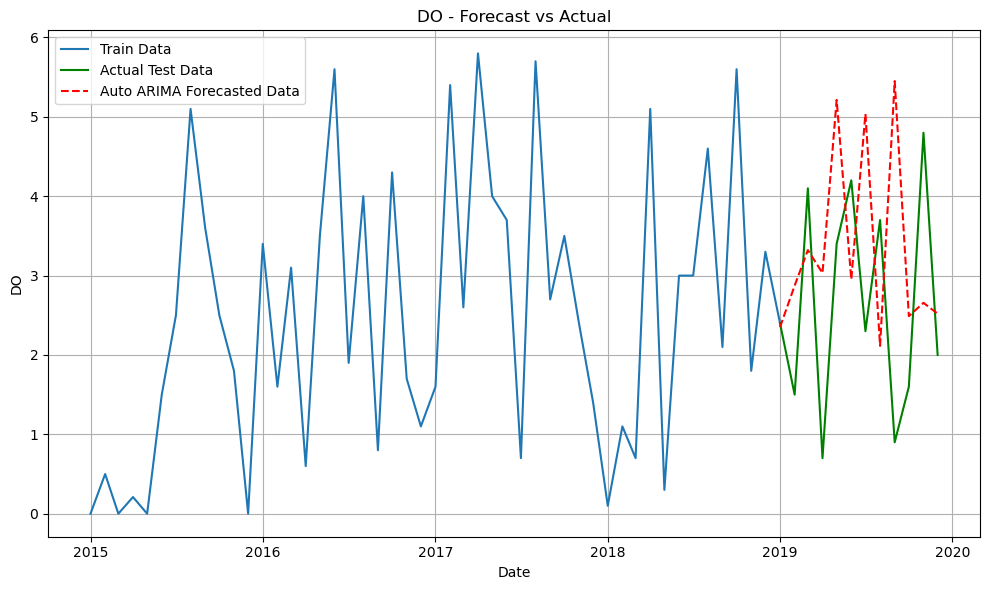

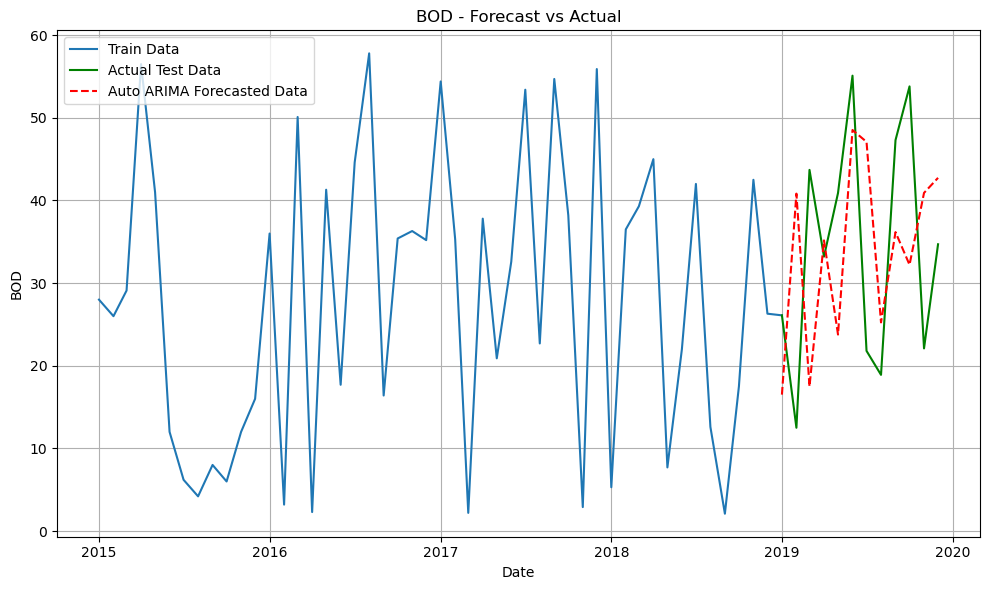

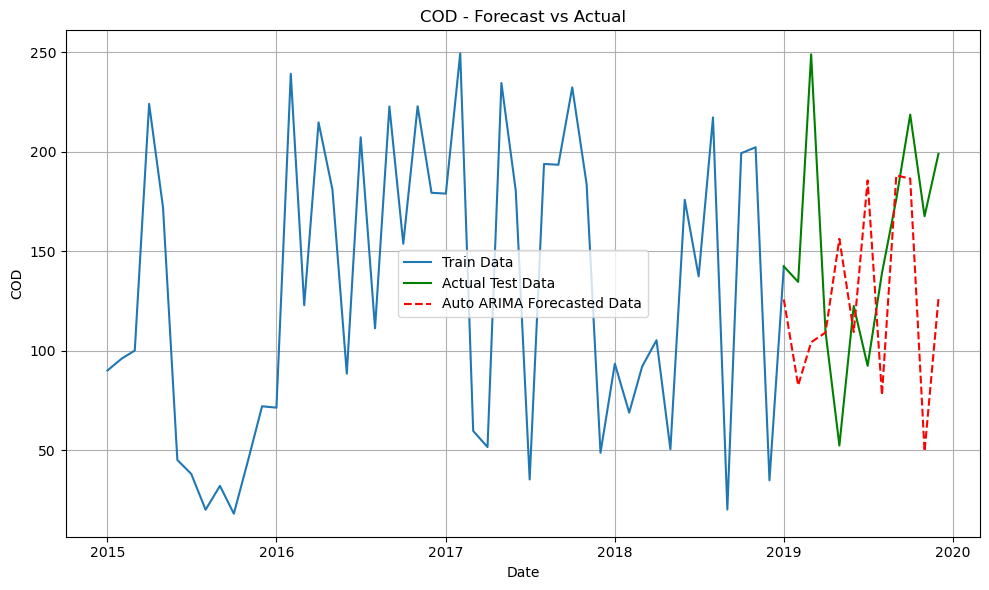

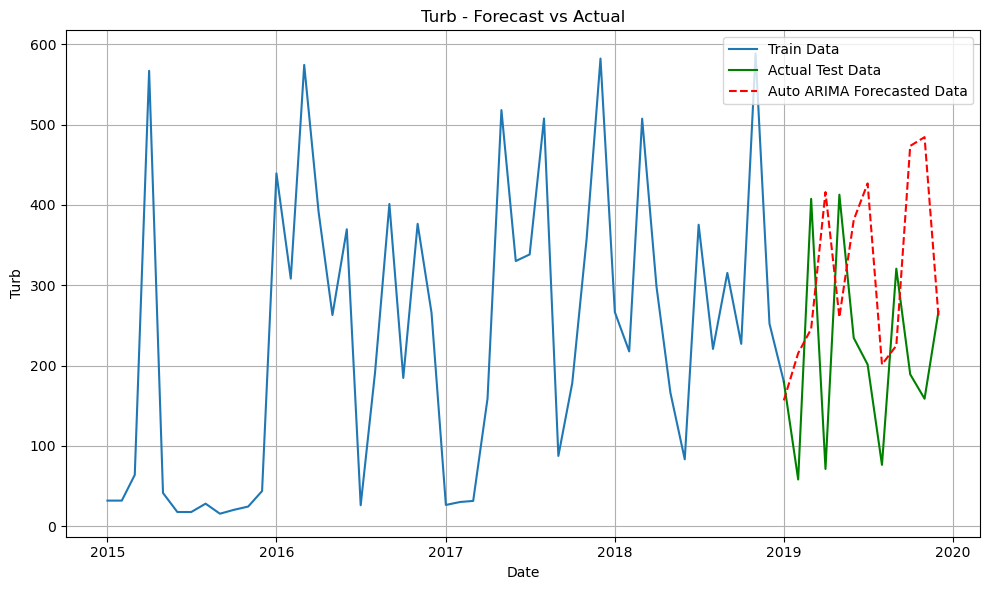

Accuracy for Temp:
  MAE: 3.0787411774934816
  MSE: 17.503726610426813
  RMSE: 4.183745524100003
  MAPE: 13.200525802964352%
----------------------------------------
Accuracy for pH:
  MAE: 0.35691934422949106
  MSE: 0.21883952251035468
  RMSE: 0.4678028671463597
  MAPE: 4.753929498773496%
----------------------------------------
Accuracy for EC:
  MAE: 581.4122927910441
  MSE: 505735.01082627795
  RMSE: 711.1504839527834
  MAPE: 88.86656462089962%
----------------------------------------
Accuracy for TA:
  MAE: 145.96408870468545
  MSE: 28373.389044285806
  RMSE: 168.44402347452345
  MAPE: 85.38282046894419%
----------------------------------------
Accuracy for Cl:
  MAE: 16.171042274177413
  MSE: 534.5736505296258
  RMSE: 23.12084882805183
  MAPE: 26.31806207329557%
----------------------------------------
Accuracy for TDS:
  MAE: 265.7447853473889
  MSE: 107748.62346840937
  RMSE: 328.2508544823751
  MAPE: 59.15608161881114%
----------------------------------------
Accuracy for TSS:

In [6]:
# Split data into training and test sets
train_data = data[data.index <= '2019-01-01']
test_data = data[data.index >= '2019-01-01']

# Create an empty DataFrame to store the predictions
auto_arima_predictions_old = pd.DataFrame()

# Number of forecast steps
forecast_steps = 12

# Loop through each column and fit the auto_arima model
for column in train_data.columns:
    
    # Fit auto_arima model
    model = auto_arima(train_data[column], 
                       start_p=1, max_p=6,     # Autoregressive terms
                   start_q=1, max_q=6,     # Moving average terms
                   seasonal=True,          # Enable seasonal ARIMA
                   m=12,                   # 12 months seasonality
                   start_P=0, max_P=4,     # Seasonal autoregressive terms
                   start_Q=0, max_Q=4,     # Seasonal moving average terms
                   d=1, D=1,               # Differencing and seasonal differencing
                   trace=True,             # Display trace of model fitting
                   error_action='ignore',  # Ignore non-viable models
                   suppress_warnings=True, # Suppress warnings
                   stepwise=True)          # Use stepwise search for better optimization

    
    # Forecast future values for the forecast period
    forecast = model.predict(n_periods=forecast_steps)
    
    # Store the forecasted values
    auto_arima_predictions_old[column] = forecast

# Set the index for the forecast to cover the forecast period
auto_arima_predictions_old.index = pd.date_range(start='2019-01-01', periods=forecast_steps, freq='MS')

# Plot the forecasted values against the actual values
for column in train_data.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data[column], label='Train Data')
    plt.plot(test_data.index, test_data[column], label='Actual Test Data', color='green')
    plt.plot(auto_arima_predictions_old.index, auto_arima_predictions_old[column], 
             label='Auto ARIMA Forecasted Data', color='red', linestyle='--')
    
    plt.title(f"{column} - Forecast vs Actual")
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Calculate and print error metrics
mae_results = {}
mse_results = {}
rmse_results = {}
mape_results = {}

# Loop through each column (feature)
for column in test_data.columns:
    actual_values = test_data[column]  # Actual test data values
    predicted_values = auto_arima_predictions_old[column]  # Forecasted values
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, predicted_values)
    mae_results[column] = mae
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(actual_values, predicted_values)
    mse_results[column] = mse
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse_results[column] = rmse
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    mape_results[column] = mape
    
    # Print results for each feature
    print(f"Accuracy for {column}:")
    print(f"  MAE: {mae}")
    print(f"  MSE: {mse}")
    print(f"  RMSE: {rmse}")
    print(f"  MAPE: {mape}%")
    print("-" * 40)


# VAR Model ( Trial )

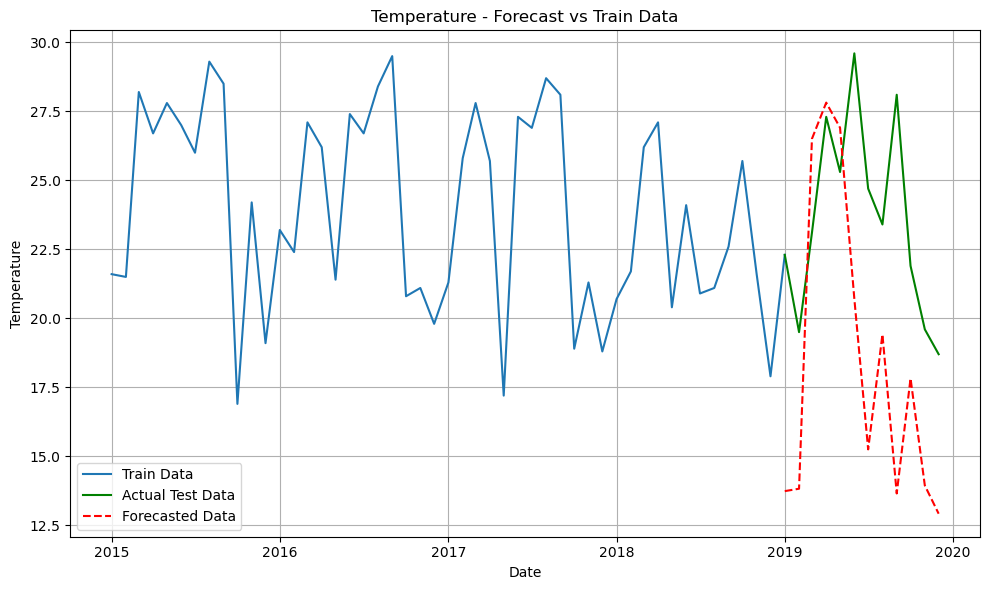

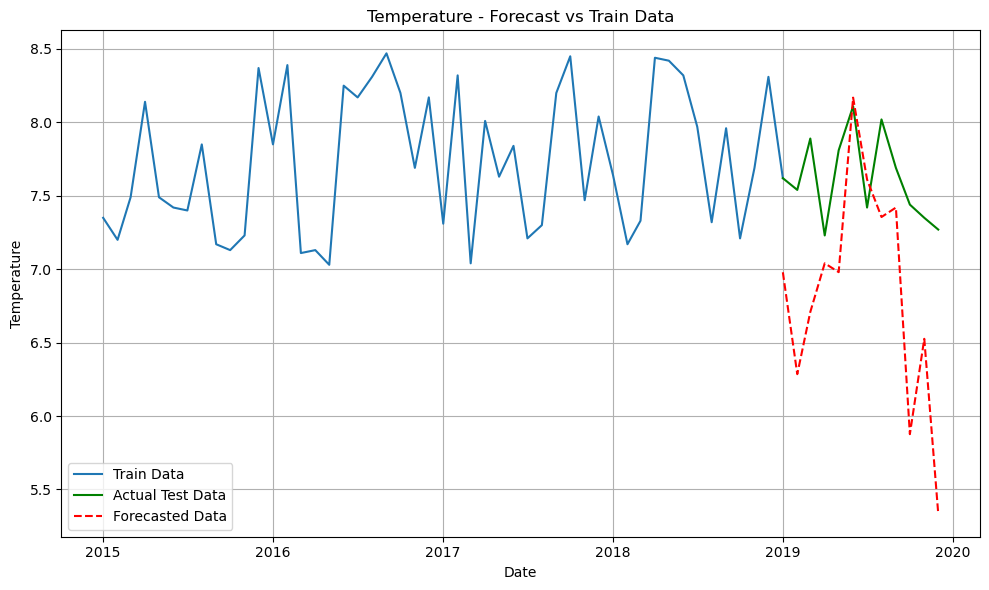

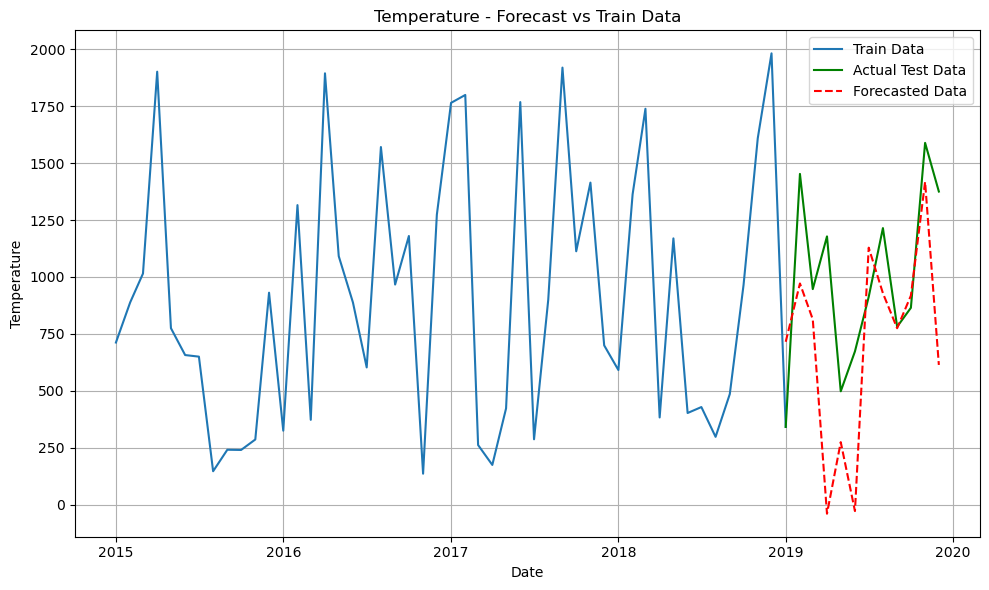

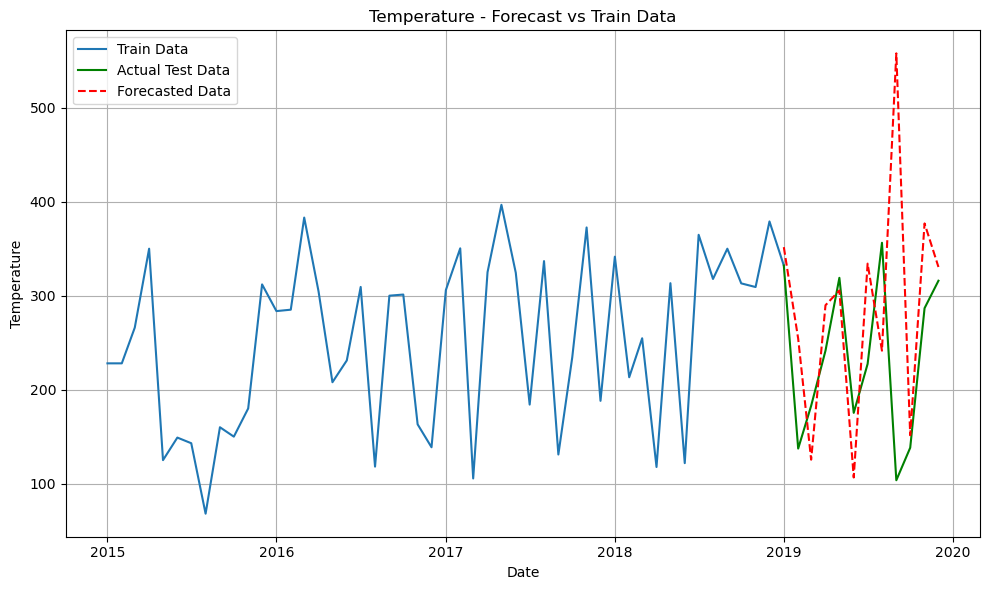

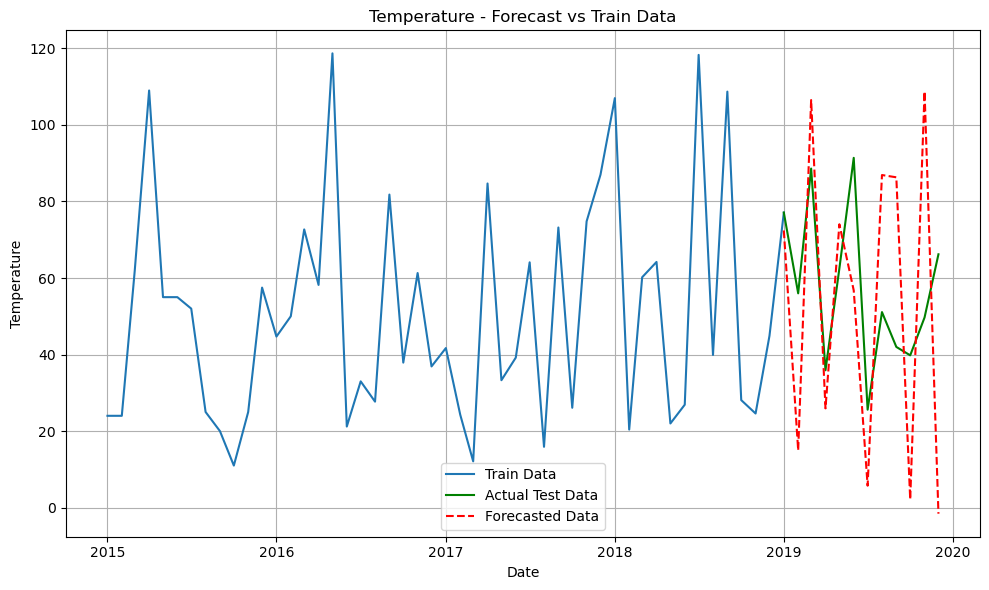

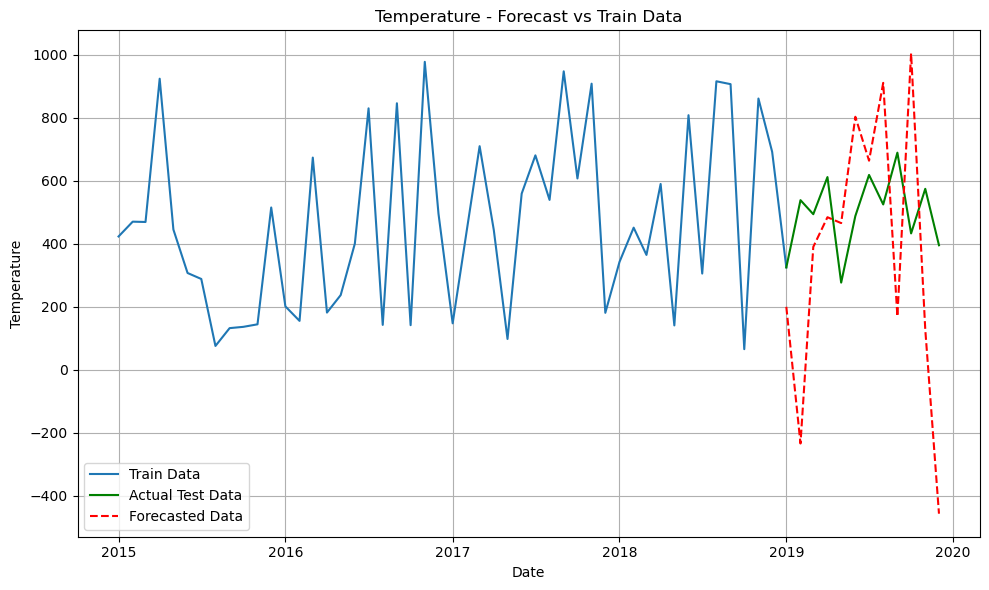

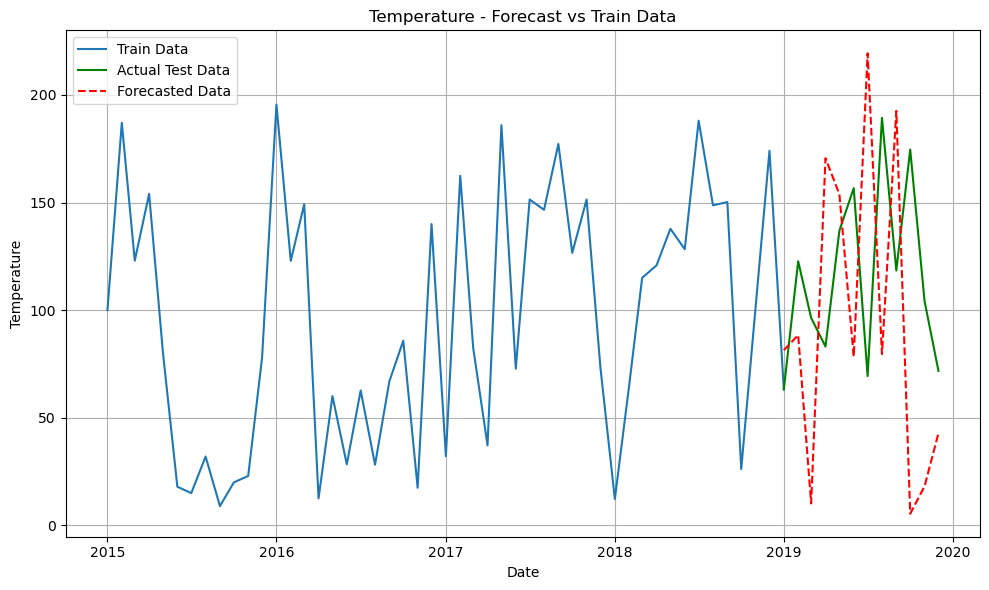

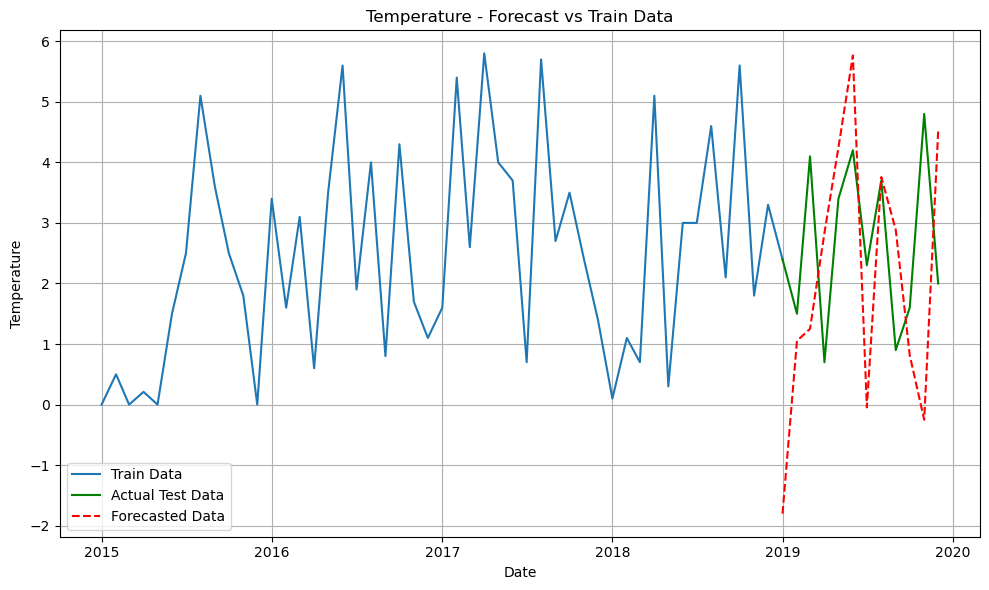

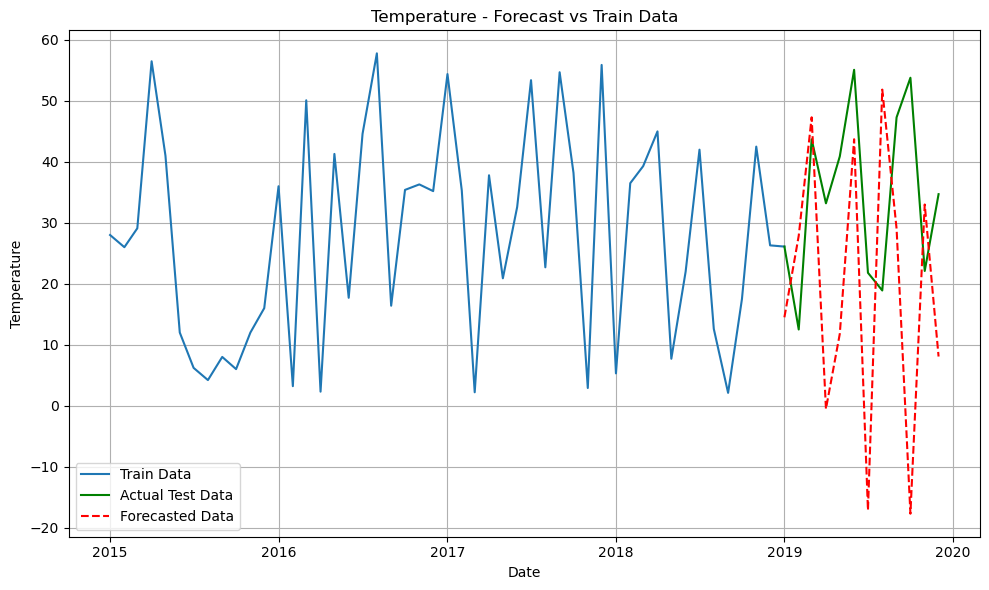

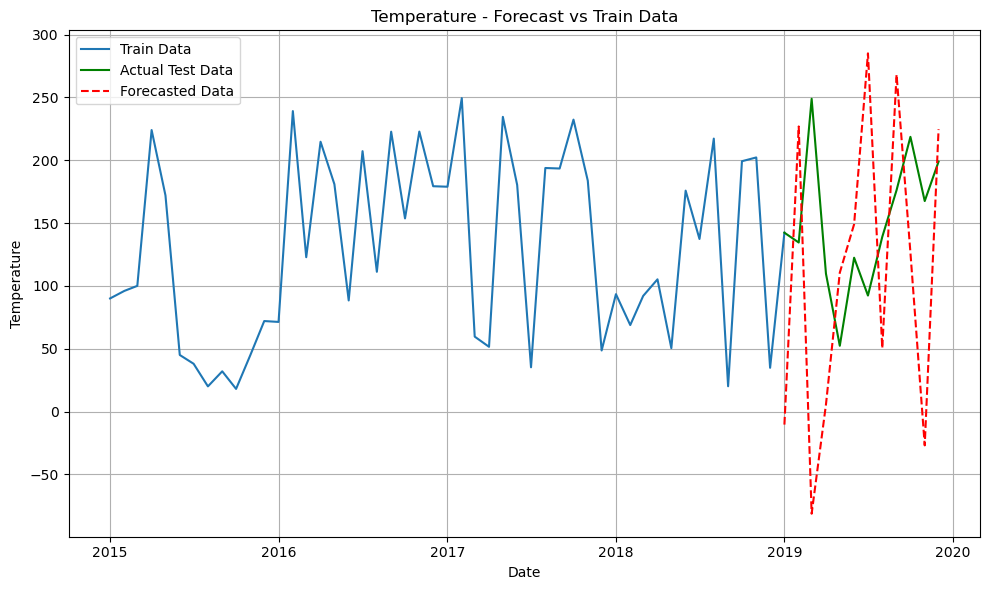

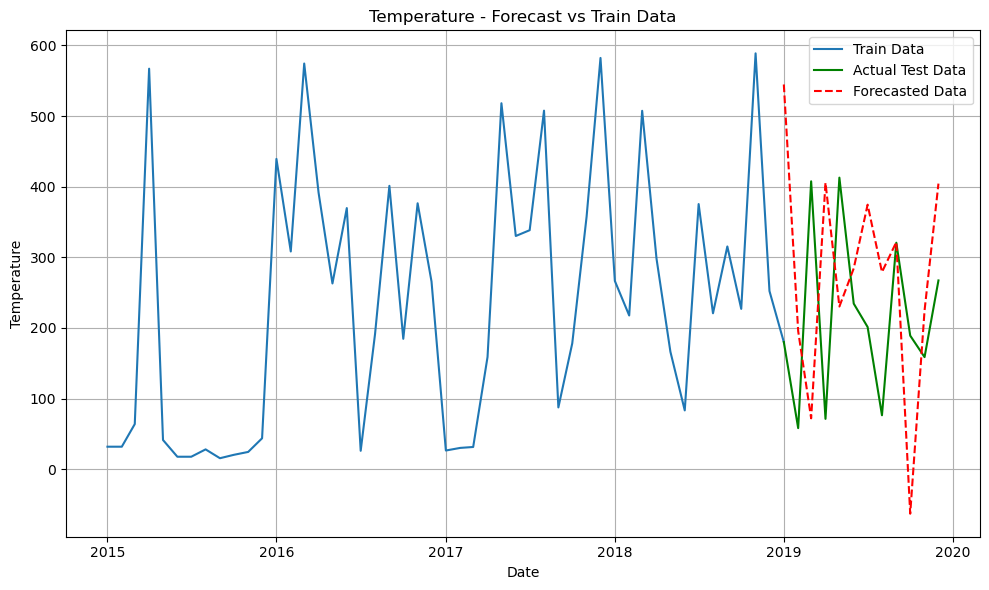

Accuracy for Temp:
  MAE: 6.003149749064497
  MSE: 49.56439547932624
  RMSE: 7.040198539766207
  MAPE: 25.461830384978246%
----------------------------------------
Accuracy for pH:
  MAE: 0.8002324059194494
  MSE: 0.9605691135756014
  RMSE: 0.9800862786385703
  MAPE: 10.600383611375348%
----------------------------------------
Accuracy for EC:
  MAE: 385.6143024348018
  MSE: 263130.8506603676
  RMSE: 512.962816060158
  MAPE: 44.14449126761679%
----------------------------------------
Accuracy for TA:
  MAE: 93.19376146400619
  MSE: 22005.102590131442
  RMSE: 148.3411695724806
  MAPE: 62.43851994066944%
----------------------------------------
Accuracy for Cl:
  MAE: 32.01442048601126
  MSE: 1382.8666123839066
  RMSE: 37.18691453164549
  MAPE: 62.71191632874413%
----------------------------------------
Accuracy for TDS:
  MAE: 371.34976921394247
  MSE: 204170.1324018959
  RMSE: 451.85189210834994
  MAPE: 78.25858664930612%
----------------------------------------
Accuracy for TSS:
  MAE

In [7]:
# Split the data into training and testing sets
train_data = data[data.index <= '2019-01-01']
test_data = data[data.index >= '2019-01-01']

# Fit the VAR model
model = VAR(train_data)
fitted_model = model.fit(maxlags=15)

# Forecast for the foorcast period
forecast_steps = 12
forecast = fitted_model.forecast(train_data.values, steps=forecast_steps)

# Convert the forecasted data into a DataFrame
forecast_index = pd.date_range(start='2019-01-01', periods=forecast_steps, freq='MS')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=train_data.columns)

# Plotting the forecast against the actual data
for column in train_data.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data[column], label='Train Data')
    plt.plot(test_data.index, test_data[column], label='Actual Test Data', color='green')
   
    plt.plot(forecast_df.index, forecast_df[column], label='Forecasted Data', color='red', linestyle='--')
    plt.title("Temperature - Forecast vs Train Data")
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Evaluate the performance of the model by calculating errors
mae_results = {}
mse_results = {}
rmse_results = {}
mape_results = {}

# Loop through each column (feature)
for column in train_data.columns:
    predicted_values = forecast_df[column]  # Forecasted values for each column
    actual_values = test_data[column] # Actual test data values

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, predicted_values)
    mae_results[column] = mae
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(actual_values, predicted_values)
    mse_results[column] = mse
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse_results[column] = rmse
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    mape_results[column] = mape
    
    # Print results for each feature
    print(f"Accuracy for {column}:")
    print(f"  MAE: {mae}")
    print(f"  MSE: {mse}")
    print(f"  RMSE: {rmse}")
    print(f"  MAPE: {mape}%")
    print("-" * 40)



# Prophet Model

15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:12 - cmdstanpy - INFO - Chain [1] done processing


Accuracy for Temp:
MAE: 2.4920685221968633, MSE: 7.5399697687148395, RMSE: 2.745900538751329


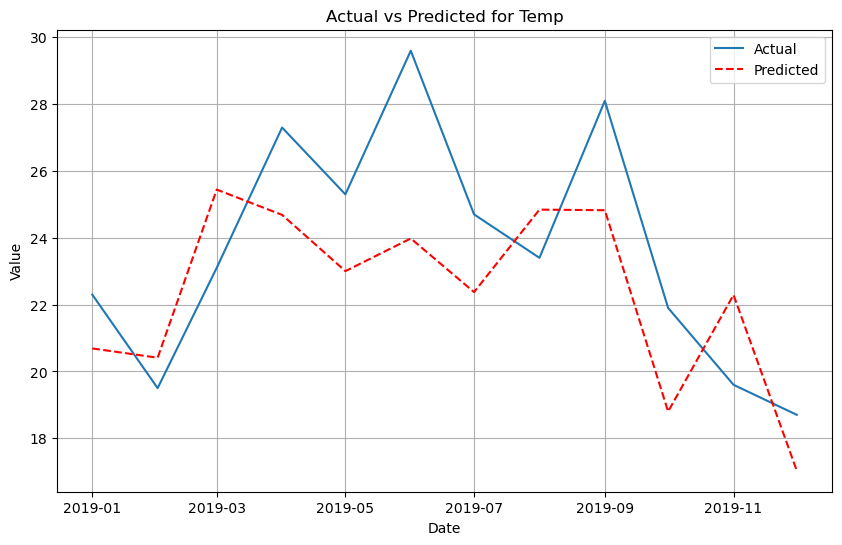

15:17:12 - cmdstanpy - INFO - Chain [1] start processing
15:17:13 - cmdstanpy - INFO - Chain [1] done processing


Accuracy for pH:
MAE: 0.44544160253793946, MSE: 0.34507954393673185, RMSE: 0.5874347146166388


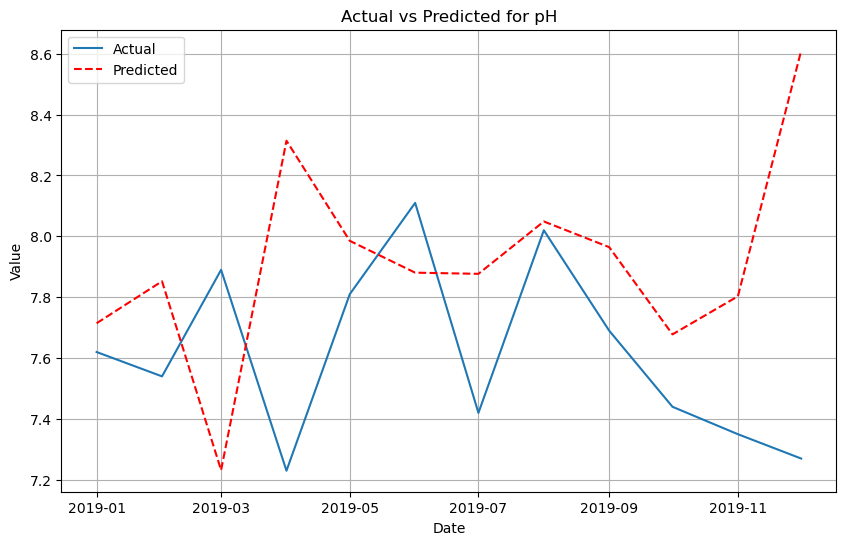

15:17:13 - cmdstanpy - INFO - Chain [1] start processing
15:17:14 - cmdstanpy - INFO - Chain [1] done processing


Accuracy for EC:
MAE: 251.18665438946724, MSE: 106755.54596616876, RMSE: 326.73467212123165


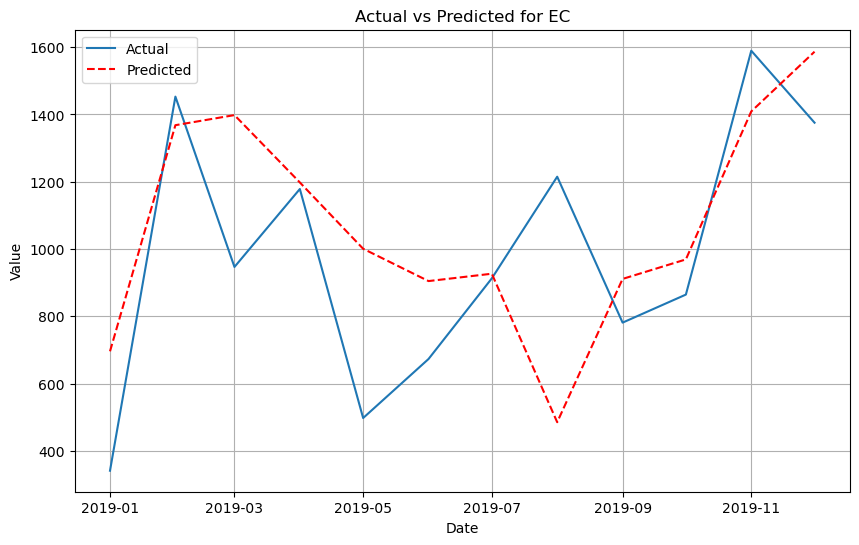

15:17:14 - cmdstanpy - INFO - Chain [1] start processing
15:17:14 - cmdstanpy - INFO - Chain [1] done processing


Accuracy for TA:
MAE: 96.0197770403109, MSE: 12747.32402719043, RMSE: 112.90404787779059


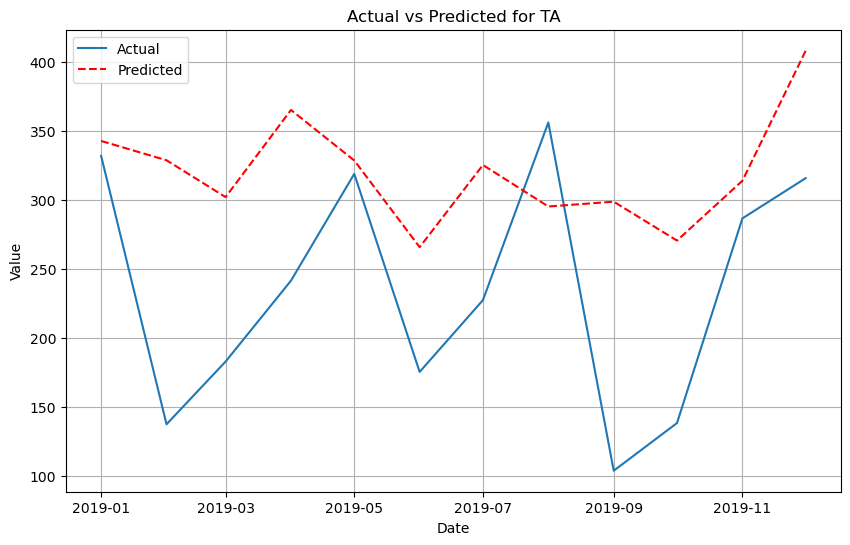

15:17:15 - cmdstanpy - INFO - Chain [1] start processing
15:17:15 - cmdstanpy - INFO - Chain [1] done processing


Accuracy for Cl:
MAE: 26.04391573236509, MSE: 1112.3877288386313, RMSE: 33.352477101987965


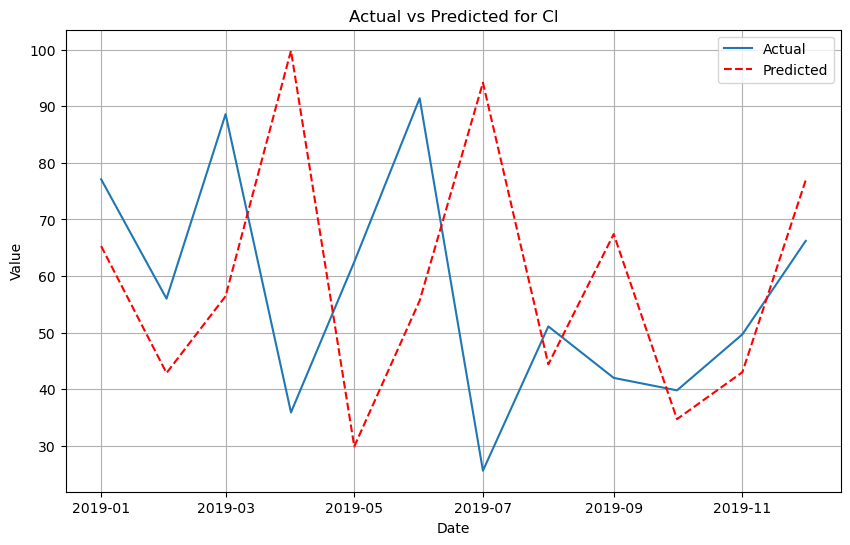

15:17:16 - cmdstanpy - INFO - Chain [1] start processing
15:17:16 - cmdstanpy - INFO - Chain [1] done processing


Accuracy for TDS:
MAE: 153.74812460871559, MSE: 37513.131007735334, RMSE: 193.68306845910752


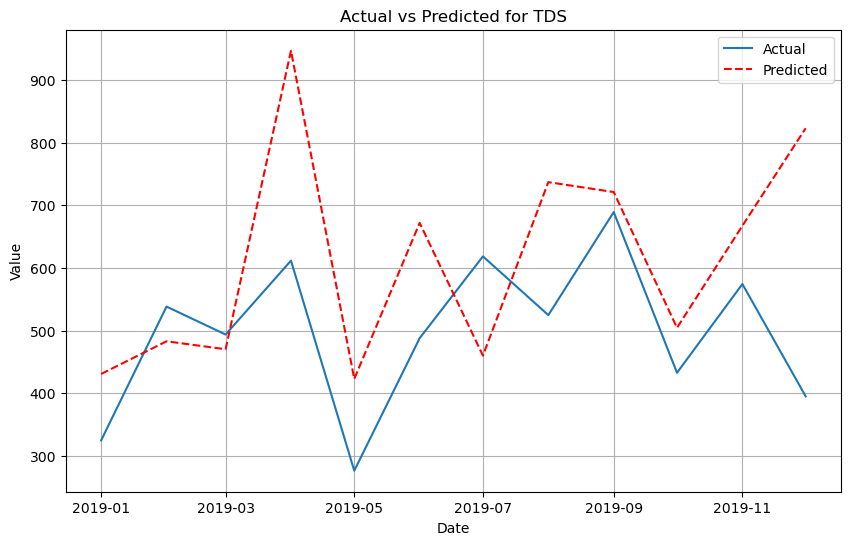

15:17:16 - cmdstanpy - INFO - Chain [1] start processing
15:17:16 - cmdstanpy - INFO - Chain [1] done processing


Accuracy for TSS:
MAE: 46.84293335975687, MSE: 3047.860833921572, RMSE: 55.207434589207026


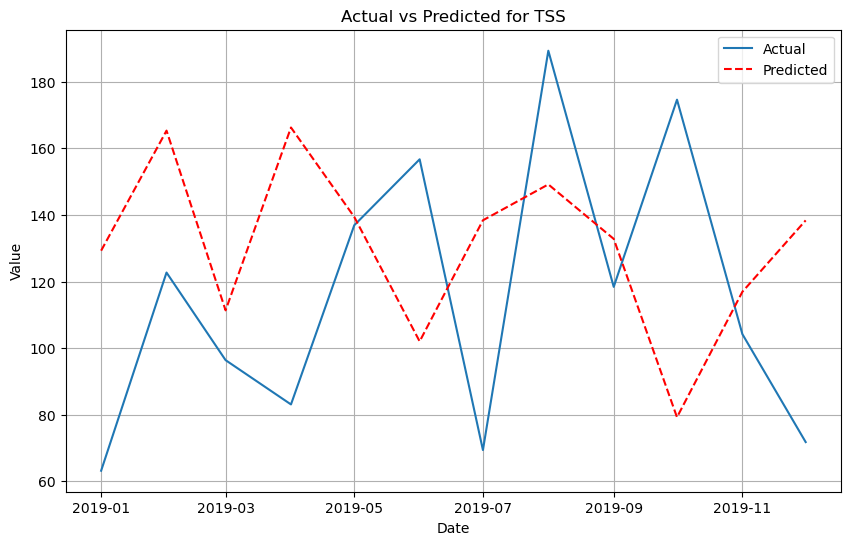

15:17:17 - cmdstanpy - INFO - Chain [1] start processing
15:17:17 - cmdstanpy - INFO - Chain [1] done processing


Accuracy for DO:
MAE: 1.8575590954969485, MSE: 4.767349981271059, RMSE: 2.1834262023872157


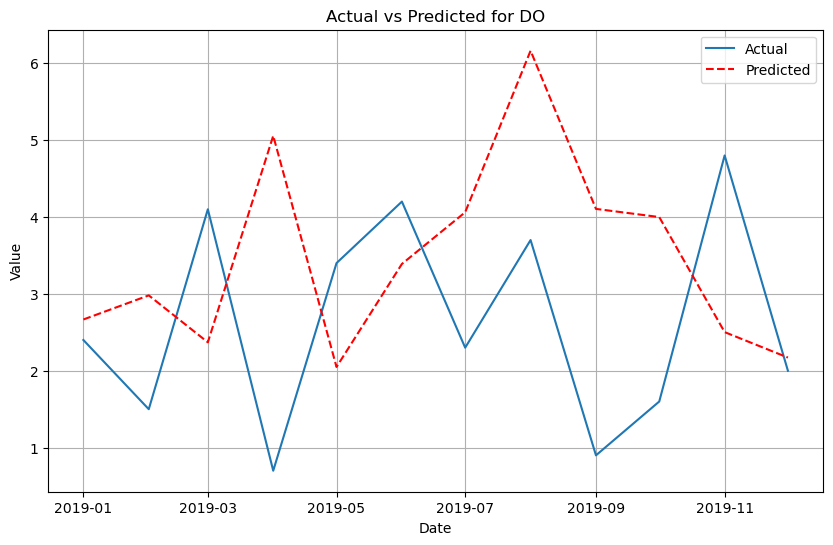

15:17:18 - cmdstanpy - INFO - Chain [1] start processing
15:17:18 - cmdstanpy - INFO - Chain [1] done processing


Accuracy for BOD:
MAE: 14.493145309468886, MSE: 294.00666227720086, RMSE: 17.146622474330066


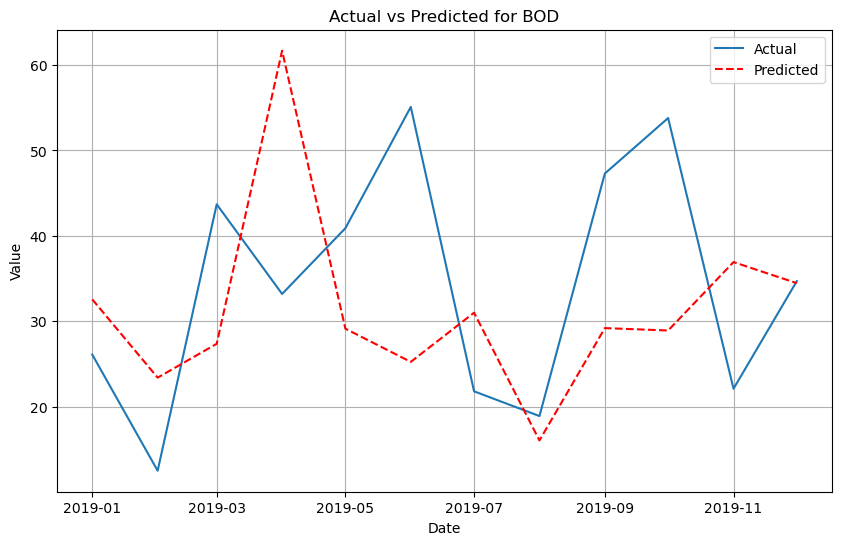

15:17:18 - cmdstanpy - INFO - Chain [1] start processing
15:17:19 - cmdstanpy - INFO - Chain [1] done processing


Accuracy for COD:
MAE: 58.56622672500904, MSE: 4852.7148442567, RMSE: 69.66143010487727


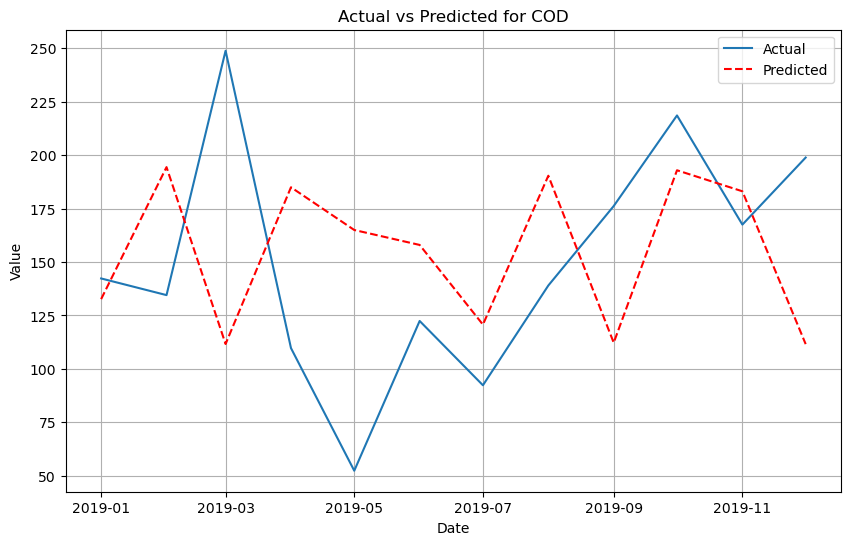

15:17:19 - cmdstanpy - INFO - Chain [1] start processing
15:17:19 - cmdstanpy - INFO - Chain [1] done processing


Accuracy for Turb:
MAE: 191.2907697090749, MSE: 58251.181001182624, RMSE: 241.3528143635011


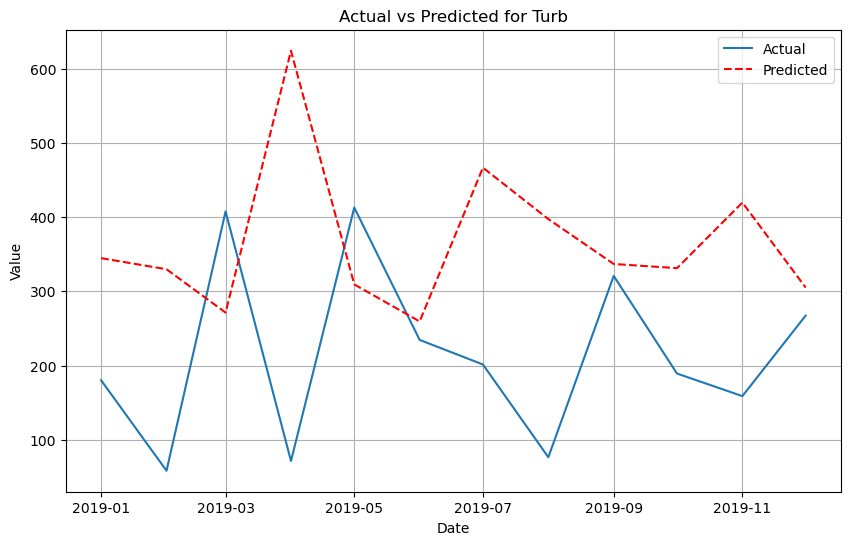

{'Temp':            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper   
0  2015-01-01  24.680969   21.091267   25.812118    24.680969    24.680969  \
1  2015-02-01  24.623105   20.667503   25.351019    24.623105    24.623105   
2  2015-03-01  24.570841   26.030492   30.526910    24.570841    24.570841   
3  2015-04-01  24.512978   25.100293   29.672172    24.512978    24.512978   
4  2015-05-01  24.456981   23.434900   28.185014    24.456981    24.456981   
..        ...        ...         ...         ...          ...          ...   
56 2019-09-01  21.499983   22.568609   27.005823    21.499976    21.499989   
57 2019-10-01  21.443976   16.417286   21.203993    21.443967    21.443983   
58 2019-11-01  21.386102   19.944523   24.730600    21.386092    21.386110   
59 2019-12-01  21.330094   14.643934   19.538139    21.330083    21.330105   
60 2020-01-01  21.272220   18.148767   22.834967    21.272207    21.272232   

    additive_terms  additive_terms_lower  additive_ter

In [8]:
#Load and prepare your data
file_path = 'Dataset.xlsx'
temp_data = pd.read_excel(file_path)
temp_data = pd.DataFrame(temp_data)

temp_data['Date'] = pd.to_datetime(temp_data['Date'])

train_data = temp_data[temp_data['Date'] <= '2019-01-01']
test_data = temp_data[temp_data['Date'] >= '2019-01-01']

forecast_results = {}
accuracy_metrics = {}

data_columns = temp_data.drop(columns=['Date']).columns

for column in data_columns:
    df_train = train_data[['Date', column]].rename(columns={'Date': 'ds', column: 'y'})
    df_test = test_data[['Date', column]].rename(columns={'Date': 'ds', column: 'y'})

    # Initialize and fit the Prophet model
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    model.fit(df_train)

    # Make future predictions
    future = model.make_future_dataframe(periods=len(df_test), freq='MS')
    forecast = model.predict(future)

    forecast_results[column] = forecast
    
    # Merge the forecast with the test data
    forecast_test = forecast.set_index('ds').join(df_test.set_index('ds'), rsuffix='_actual')
    forecast_test = forecast_test.dropna()

    mae = mean_absolute_error(forecast_test['y'], forecast_test['yhat'])
    mse = mean_squared_error(forecast_test['y'], forecast_test['yhat'])
    rmse = np.sqrt(mse)
    
    # Store accuracy metrics for this column
    accuracy_metrics[column] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
    
    # Print accuracy metrics for the column
    print(f'Accuracy for {column}:')
    print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')
    

     # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_test.index, forecast_test['y'], label='Actual')
    plt.plot(forecast_test.index, forecast_test['yhat'], label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted for {column}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    #print(forecast_results)

print(forecast_results)

# VAR Final

In [9]:
# Forecast for the next 24 months (2 years)
forecast_steps = 24

# Fit the VAR model
model = VAR(data)
fitted_model = model.fit(maxlags=22) # (22-24) lags to capture yearly seasonality

# Forecast for the forecast period
forecast = fitted_model.forecast(data.values, steps=forecast_steps)

# Convert the forecasted data into a DataFrame
forecast_index = pd.date_range(start='2020-01-01', periods=forecast_steps, freq='MS')
var_predictions_full = pd.DataFrame(forecast, index=forecast_index, columns=data.columns)

# Auto Arima Final 

In [10]:
# Initialize an empty DataFrame to store predictions
auto_arima_predictions_full = pd.DataFrame()
forecast_steps = 24 # Forecast for 24 months (2 years)

# Loop through each column and fit the auto_arima model
for column in data.columns:
    
    # Fit auto_arima model
    model = auto_arima( data[column], 
                        start_p=1, max_p=6,     # Autoregressive terms
                        start_q=1, max_q=6,     # Moving average terms
                        seasonal=True,          # Enable seasonal ARIMA
                        m=12,                   # 12 months seasonality
                        start_P=0, max_P=4,     # Seasonal autoregressive terms
                        start_Q=0, max_Q=4,     # Seasonal moving average terms
                        d=1, D=1,               # Differencing and seasonal differencing
                        trace=True,             # Display trace of model fitting
                        error_action='ignore',  # Ignore non-viable models
                        suppress_warnings=True, # Suppress warnings
                        stepwise=True)          # Use stepwise search for better optimization

    
    # Forecast future values for forecast period
    forecast = model.predict(n_periods=forecast_steps)
    
    # Store the forecasted values
    auto_arima_predictions_full[column] = forecast

# Set the index for the forecast to cover the forecast period
auto_arima_predictions_full.index = pd.date_range(start='2020-01-01', periods=forecast_steps, freq='MS')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=262.097, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=258.991, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=259.728, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=259.637, Time=0.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=257.824, Time=0.08 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=258.850, Time=0.17 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=260.391, Time=0.05 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=256.809, Time=0.09 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=259.190, Time=0.02 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=inf, Time=

# Sarima Final

In [11]:
forecast_steps = 24  # 24 months to forecast

# Initialize an empty DataFrame to store predictions
sarima_predictions_full = pd.DataFrame()

# Loop over each column in the data (each feature)
for column in data.columns:

    # Fit SARIMA model (P=1, D=1, Q=1, S=12 for yearly seasonality)
    model = SARIMAX(data[column], 
                    order=(1, 1, 1), 
                    seasonal_order=(1, 1, 1, 12))
    
    fitted_model = model.fit(disp=True)
    
    # Forecast future values for the forecast period
    forecast = fitted_model.forecast(steps=forecast_steps)
    
    # Store the forecasted values
    sarima_predictions_full[column] = forecast

# Set the index for predictions to the forecast period
sarima_predictions_full.index = pd.date_range(start='2020-01-01', periods=forecast_steps, freq='MS')


# Calculate CCME-WQI

In [12]:
# Reference values for CCME WQI calculation
reference_values = {
    'pH': (6.5, 8.5),
    'EC': 1200,
    'TA': 150,
    'Cl': (150, 650),
    'TDS': 2100,
    'TSS': 150,
    'DO': 5,
    'BOD': 6,
    'COD': 200,
    'Turb': 10
}

# Features with lower bounds
lowerBoundFeatures =['DO']

# Define a function to calculate excursions
def calculate_excursion_single(value, threshold, is_upper_bound):
    
    if value == 0:
        
        # Avoid division by zero, return 0 or an appropriate value
        epsilon = 0.0001 
        return (threshold /(value + epsilon)) - 1
        
    if is_upper_bound:
        # If the value exceeds the upper bound, calculate the excursion normally
        return (value / threshold) - 1 
    else:
        # If the value is below the lower bound, calculate the excursion
        return (threshold / value) - 1

# Define a function to calculate the CCME WQI
def calculate_ccme_wqi(predicted_df, reference_values,lowerBoundFeatures):

    scope_failures = 0
    frequency_failures = 0
    sum_of_excursions = 0
    total_tests = 0

    # Loop through each parameter in the reference values
    for param in reference_values:
        
        # If parameter has both lower and upper bounds (e.g., pH, Cl)
        if isinstance(reference_values[param], tuple):
            
            # Extract the lower and upper bounds
            lower_bound, upper_bound = reference_values[param]
            
            # Scope failure check
            if predicted_df[(predicted_df[param] < lower_bound) | (predicted_df[param] > upper_bound)].shape[0] > 0:
                scope_failures += 1
            
            # Frequency failure check
            frequency_failures += predicted_df[param].apply(lambda x: x < lower_bound or x > upper_bound).sum()
            
            # Sum of excursions
            sum_of_excursions += predicted_df[param].apply(
                lambda x: calculate_excursion_single(x, upper_bound, True) if x > upper_bound 
                else calculate_excursion_single(x, lower_bound, False) if x < lower_bound 
                else 0
            ).sum()
        
        # For parameters with only upper bounds (e.g., TDS, COD)
        elif param not in lowerBoundFeatures: 
            
            # Extract the upper bound
            upper_bound = reference_values[param]
            
            # Scope failure check
            if predicted_df[predicted_df[param] > upper_bound].shape[0] > 0:
                scope_failures += 1
            
            # Frequency failure check
            frequency_failures += predicted_df[param].apply(lambda x: x > upper_bound).sum()
            
            # Sum of excursions
            sum_of_excursions += predicted_df[param].apply(
                lambda x: calculate_excursion_single(x, upper_bound, True) if x > upper_bound else 0
            ).sum()
        
        # For parameters with only lower bounds (e.g., DO)
        elif param in lowerBoundFeatures:
            
            # Extract the lower bound
            lower_bound = reference_values[param]
            
            # Scope failure check
            if predicted_df[predicted_df[param] < lower_bound].shape[0] > 0:
                scope_failures += 1
            
            # Frequency failure check
            frequency_failures += predicted_df[param].apply(lambda x: x < lower_bound).sum()
            
            # Sum of excursions
            sum_of_excursions += predicted_df[param].apply(
                lambda x: calculate_excursion_single(x, lower_bound, False) if x < lower_bound else 0
            ).sum()

        total_tests += predicted_df[param].notnull().sum()

    # Calculate F1, F2, F3, and CCME WQI
    F1 = (scope_failures / len(reference_values)) * 100

    F2 = (frequency_failures / total_tests) * 100

    nse = sum_of_excursions / total_tests
    F3 = (nse / (0.01 * nse + 0.01))

    ccme_wqi = 100 - (np.sqrt(F1**2 + F2**2 + F3**2) / 1.732)
    
    return ccme_wqi


Year  Season      
2015  Winter          25.573337
      Pre Monsoon     19.158034
      Monsoon         57.854500
      Post Monsoon    51.387279
2016  Winter          19.170356
      Pre Monsoon     30.097391
      Monsoon         32.470773
      Post Monsoon    34.826751
2017  Winter          29.794779
      Pre Monsoon     34.487929
      Monsoon         30.509964
      Post Monsoon    27.161175
2018  Winter          32.998018
      Pre Monsoon     35.328477
      Monsoon         33.445533
      Post Monsoon    29.525428
2019  Winter          34.520230
      Pre Monsoon     34.724564
      Monsoon         32.920302
      Post Monsoon    28.793352
2020  Winter          37.133613
      Pre Monsoon     27.412292
      Monsoon         38.179881
      Post Monsoon    28.929881
2021  Winter          28.054574
      Pre Monsoon     25.484646
      Monsoon         38.166287
      Post Monsoon    30.762483
2022  Winter          32.843387
dtype: float64


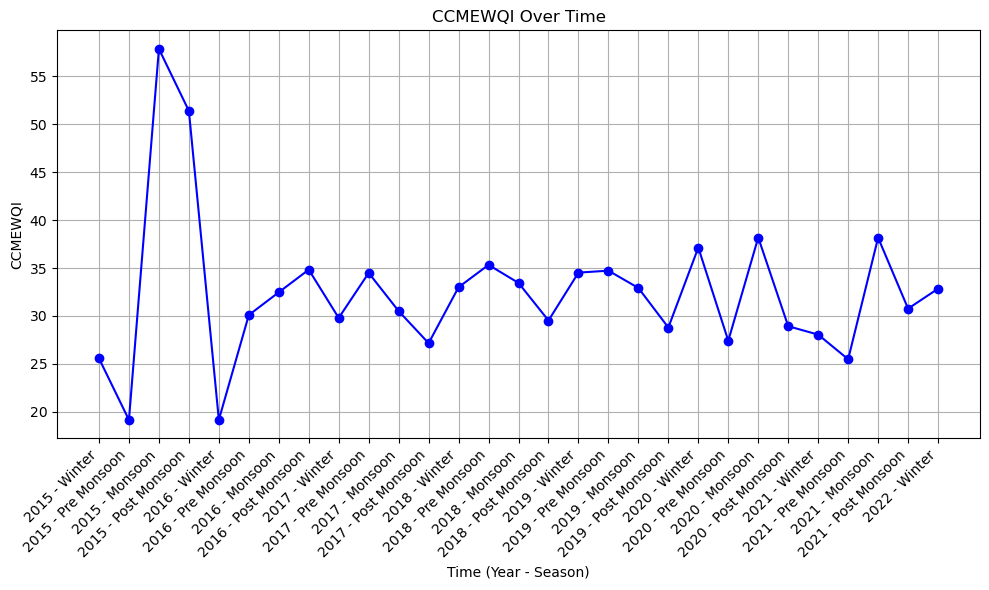

In [13]:
# Combine the data and the forecasted values

# To use SARIMA predictions, uncomment the line below
df = pd.concat([data, sarima_predictions_full])

# To use Auto ARIMA predictions, uncomment the line below
#df = pd.concat([data, auto_arima_predictions_full])

# To use VAR predictions, uncomment the line below
#df = pd.concat([data, var_predictions_full])

# Reset the index
df.index.name = 'Date'
df.reset_index(inplace=True)

# Convert 'Date' to datetime and extract 'Year' and 'Month'
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df.loc[df['Date'].dt.month == 12, 'Year'] = df['Date'].dt.year + 1

df['Month'] = df['Date'].dt.month_name()

# Map months to seasons
season_order = ['Winter', 'Pre Monsoon', 'Monsoon', 'Post Monsoon']

season_mapping = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Pre Monsoon', 'April': 'Pre Monsoon', 'May': 'Pre Monsoon',
    'June': 'Monsoon', 'July': 'Monsoon', 'August': 'Monsoon', 'September': 'Monsoon',
    'October': 'Post Monsoon', 'November': 'Post Monsoon'
}

# Add a 'Season' column
df['Season'] = df['Month'].map(season_mapping)
df['Season'] = pd.Categorical(df['Season'], categories=season_order, ordered=True)

# Define Lower Bound Features
lowerBoundFeatures = ['DO']

# Group by 'Year' and 'Season'
print(df.groupby(['Year', 'Season']))

# Calculate CCME WQI for each group
ccmewqi_results = df.groupby(['Year', 'Season']).apply(lambda group: calculate_ccme_wqi(group, reference_values,lowerBoundFeatures))

# Sort the results by 'Year' and 'Season'
ccmewqi_results = ccmewqi_results.sort_index(level=['Year', 'Season'])

print(ccmewqi_results)

# Plot the CCMEWQI over time
df['Time'] = df['Year'].astype(str) + " - " + df['Season'].astype(str)
plt.figure(figsize=(10, 6))
plt.plot(df['Time'].unique(), ccmewqi_results, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xticks(rotation=45, ha='right')
plt.xlabel('Time (Year - Season)')
plt.ylabel('CCMEWQI')
plt.title('CCMEWQI Over Time')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
